In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 1012)
(772408, 8)
validation
(101248, 1012)
(101248, 8)
test
(98888, 1012)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1012)]            0         


 dense (Dense)               (None, 1024)              1037312   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1727368 (6.59 MB)


Trainable params: 1727368 (6.59 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:43 - loss: 2.1477 - STD: 0.0616 - MAE: 0.2194

 4/78 [>.............................] - ETA: 1s - loss: 1.6354 - STD: 0.1324 - MAE: 0.1755  

 7/78 [=>............................] - ETA: 1s - loss: 1.5365 - STD: 0.1837 - MAE: 0.1530

10/78 [==>...........................] - ETA: 1s - loss: 1.4737 - STD: 0.1964 - MAE: 0.1465

13/78 [====>.........................] - ETA: 1s - loss: 1.4401 - STD: 0.1916 - MAE: 0.1476

16/78 [=====>........................] - ETA: 1s - loss: 1.4224 - STD: 0.1860 - MAE: 0.1495

19/78 [======>.......................] - ETA: 1s - loss: 1.4070 - STD: 0.1854 - MAE: 0.1494

21/78 [=======>......................] - ETA: 1s - loss: 1.3994 - STD: 0.1873 - MAE: 0.1486

24/78 [========>.....................] - ETA: 1s - loss: 1.3906 - STD: 0.1908 - MAE: 0.1470

27/78 [=========>....................] - ETA: 1s - loss: 1.3845 - STD: 0.1928 - MAE: 0.1462

30/78 [==========>...................] - ETA: 1s - loss: 1.3791 - STD: 0.1926 - MAE: 0.1462

32/78 [===========>..................] - ETA: 1s - loss: 1.3746 - STD: 0.1918 - MAE: 0.1464

34/78 [============>.................] - ETA: 1s - loss: 1.3712 - STD: 0.1910 - MAE: 0.1466

37/78 [=============>................] - ETA: 0s - loss: 1.3671 - STD: 0.1905 - MAE: 0.1467

40/78 [==============>...............] - ETA: 0s - loss: 1.3639 - STD: 0.1909 - MAE: 0.1465

43/78 [===============>..............] - ETA: 0s - loss: 1.3605 - STD: 0.1915 - MAE: 0.1462

46/78 [================>.............] - ETA: 0s - loss: 1.3581 - STD: 0.1917 - MAE: 0.1461

49/78 [=================>............] - ETA: 0s - loss: 1.3560 - STD: 0.1915 - MAE: 0.1462

52/78 [===================>..........] - ETA: 0s - loss: 1.3536 - STD: 0.1910 - MAE: 0.1463

53/78 [===================>..........] - ETA: 0s - loss: 1.3534 - STD: 0.1909 - MAE: 0.1463

56/78 [====================>.........] - ETA: 0s - loss: 1.3508 - STD: 0.1909 - MAE: 0.1463

59/78 [=====================>........] - ETA: 0s - loss: 1.3490 - STD: 0.1912 - MAE: 0.1461

62/78 [======================>.......] - ETA: 0s - loss: 1.3474 - STD: 0.1914 - MAE: 0.1460

64/78 [=======================>......] - ETA: 0s - loss: 1.3462 - STD: 0.1914 - MAE: 0.1460

66/78 [========================>.....] - ETA: 0s - loss: 1.3454 - STD: 0.1914 - MAE: 0.1460

68/78 [=========================>....] - ETA: 0s - loss: 1.3448 - STD: 0.1913 - MAE: 0.1460

70/78 [=========================>....] - ETA: 0s - loss: 1.3439 - STD: 0.1912 - MAE: 0.1460

72/78 [==========================>...] - ETA: 0s - loss: 1.3431 - STD: 0.1911 - MAE: 0.1460

74/78 [===========================>..] - ETA: 0s - loss: 1.3424 - STD: 0.1912 - MAE: 0.1460

76/78 [============================>.] - ETA: 0s - loss: 1.3416 - STD: 0.1912 - MAE: 0.1460

78/78 [==============================] - 5s 42ms/step - loss: 1.3409 - STD: 0.1912 - MAE: 0.1460 - val_loss: 1.2693 - val_STD: 0.1922 - val_MAE: 0.1445


Epoch 2/10000


 1/78 [..............................] - ETA: 4s - loss: 1.3130 - STD: 0.1923 - MAE: 0.1450

 3/78 [>.............................] - ETA: 2s - loss: 1.3152 - STD: 0.1918 - MAE: 0.1452

 5/78 [>.............................] - ETA: 1s - loss: 1.3137 - STD: 0.1913 - MAE: 0.1452

 7/78 [=>............................] - ETA: 1s - loss: 1.3070 - STD: 0.1912 - MAE: 0.1449

 9/78 [==>...........................] - ETA: 1s - loss: 1.3091 - STD: 0.1914 - MAE: 0.1450

11/78 [===>..........................] - ETA: 1s - loss: 1.3093 - STD: 0.1916 - MAE: 0.1450

13/78 [====>.........................] - ETA: 1s - loss: 1.3073 - STD: 0.1915 - MAE: 0.1449

15/78 [====>.........................] - ETA: 1s - loss: 1.3080 - STD: 0.1913 - MAE: 0.1451

17/78 [=====>........................] - ETA: 1s - loss: 1.3076 - STD: 0.1911 - MAE: 0.1451

19/78 [======>.......................] - ETA: 1s - loss: 1.3062 - STD: 0.1909 - MAE: 0.1452

22/78 [=======>......................] - ETA: 1s - loss: 1.3050 - STD: 0.1909 - MAE: 0.1450

24/78 [========>.....................] - ETA: 1s - loss: 1.3034 - STD: 0.1911 - MAE: 0.1449

26/78 [=========>....................] - ETA: 1s - loss: 1.3016 - STD: 0.1911 - MAE: 0.1448

28/78 [=========>....................] - ETA: 1s - loss: 1.3002 - STD: 0.1913 - MAE: 0.1447

30/78 [==========>...................] - ETA: 1s - loss: 1.2980 - STD: 0.1914 - MAE: 0.1446

32/78 [===========>..................] - ETA: 1s - loss: 1.2950 - STD: 0.1914 - MAE: 0.1445

34/78 [============>.................] - ETA: 1s - loss: 1.2923 - STD: 0.1916 - MAE: 0.1443

36/78 [============>.................] - ETA: 1s - loss: 1.2900 - STD: 0.1918 - MAE: 0.1441

38/78 [=============>................] - ETA: 1s - loss: 1.2877 - STD: 0.1919 - MAE: 0.1440

40/78 [==============>...............] - ETA: 1s - loss: 1.2850 - STD: 0.1924 - MAE: 0.1437

42/78 [===============>..............] - ETA: 0s - loss: 1.2826 - STD: 0.1927 - MAE: 0.1435

44/78 [===============>..............] - ETA: 0s - loss: 1.2798 - STD: 0.1930 - MAE: 0.1433

46/78 [================>.............] - ETA: 0s - loss: 1.2772 - STD: 0.1932 - MAE: 0.1431

48/78 [=================>............] - ETA: 0s - loss: 1.2750 - STD: 0.1934 - MAE: 0.1430

50/78 [==================>...........] - ETA: 0s - loss: 1.2730 - STD: 0.1935 - MAE: 0.1429

52/78 [===================>..........] - ETA: 0s - loss: 1.2704 - STD: 0.1938 - MAE: 0.1427

54/78 [===================>..........] - ETA: 0s - loss: 1.2686 - STD: 0.1939 - MAE: 0.1426

56/78 [====================>.........] - ETA: 0s - loss: 1.2664 - STD: 0.1941 - MAE: 0.1425

58/78 [=====================>........] - ETA: 0s - loss: 1.2638 - STD: 0.1942 - MAE: 0.1424

61/78 [======================>.......] - ETA: 0s - loss: 1.2600 - STD: 0.1944 - MAE: 0.1422

63/78 [=======================>......] - ETA: 0s - loss: 1.2578 - STD: 0.1945 - MAE: 0.1421

65/78 [========================>.....] - ETA: 0s - loss: 1.2551 - STD: 0.1948 - MAE: 0.1419

67/78 [========================>.....] - ETA: 0s - loss: 1.2520 - STD: 0.1950 - MAE: 0.1418

69/78 [=========================>....] - ETA: 0s - loss: 1.2493 - STD: 0.1951 - MAE: 0.1416

71/78 [==========================>...] - ETA: 0s - loss: 1.2467 - STD: 0.1953 - MAE: 0.1414

73/78 [===========================>..] - ETA: 0s - loss: 1.2440 - STD: 0.1956 - MAE: 0.1412

76/78 [============================>.] - ETA: 0s - loss: 1.2401 - STD: 0.1959 - MAE: 0.1411

78/78 [==============================] - 2s 30ms/step - loss: 1.2374 - STD: 0.1959 - MAE: 0.1410 - val_loss: 1.1325 - val_STD: 0.2048 - val_MAE: 0.1353


Epoch 3/10000


 1/78 [..............................] - ETA: 4s - loss: 1.1458 - STD: 0.2046 - MAE: 0.1349

 3/78 [>.............................] - ETA: 2s - loss: 1.1465 - STD: 0.2040 - MAE: 0.1355

 5/78 [>.............................] - ETA: 2s - loss: 1.1429 - STD: 0.2030 - MAE: 0.1357

 7/78 [=>............................] - ETA: 2s - loss: 1.1391 - STD: 0.2024 - MAE: 0.1357

 9/78 [==>...........................] - ETA: 1s - loss: 1.1357 - STD: 0.2030 - MAE: 0.1354

11/78 [===>..........................] - ETA: 1s - loss: 1.1335 - STD: 0.2025 - MAE: 0.1355

13/78 [====>.........................] - ETA: 1s - loss: 1.1312 - STD: 0.2032 - MAE: 0.1352

15/78 [====>.........................] - ETA: 1s - loss: 1.1298 - STD: 0.2026 - MAE: 0.1354

18/78 [=====>........................] - ETA: 1s - loss: 1.1296 - STD: 0.2027 - MAE: 0.1355

20/78 [======>.......................] - ETA: 1s - loss: 1.1276 - STD: 0.2029 - MAE: 0.1353

22/78 [=======>......................] - ETA: 1s - loss: 1.1242 - STD: 0.2029 - MAE: 0.1352

24/78 [========>.....................] - ETA: 1s - loss: 1.1228 - STD: 0.2032 - MAE: 0.1350

26/78 [=========>....................] - ETA: 1s - loss: 1.1203 - STD: 0.2030 - MAE: 0.1350

28/78 [=========>....................] - ETA: 1s - loss: 1.1192 - STD: 0.2031 - MAE: 0.1349

30/78 [==========>...................] - ETA: 1s - loss: 1.1166 - STD: 0.2030 - MAE: 0.1349

32/78 [===========>..................] - ETA: 1s - loss: 1.1144 - STD: 0.2034 - MAE: 0.1346

34/78 [============>.................] - ETA: 1s - loss: 1.1131 - STD: 0.2034 - MAE: 0.1346

36/78 [============>.................] - ETA: 1s - loss: 1.1111 - STD: 0.2032 - MAE: 0.1346

38/78 [=============>................] - ETA: 1s - loss: 1.1093 - STD: 0.2033 - MAE: 0.1345

40/78 [==============>...............] - ETA: 0s - loss: 1.1062 - STD: 0.2036 - MAE: 0.1342

42/78 [===============>..............] - ETA: 0s - loss: 1.1033 - STD: 0.2036 - MAE: 0.1341

45/78 [================>.............] - ETA: 0s - loss: 1.1005 - STD: 0.2037 - MAE: 0.1339

47/78 [=================>............] - ETA: 0s - loss: 1.0988 - STD: 0.2039 - MAE: 0.1338

50/78 [==================>...........] - ETA: 0s - loss: 1.0960 - STD: 0.2041 - MAE: 0.1336

53/78 [===================>..........] - ETA: 0s - loss: 1.0925 - STD: 0.2044 - MAE: 0.1333

55/78 [====================>.........] - ETA: 0s - loss: 1.0904 - STD: 0.2047 - MAE: 0.1331

57/78 [====================>.........] - ETA: 0s - loss: 1.0883 - STD: 0.2048 - MAE: 0.1330

59/78 [=====================>........] - ETA: 0s - loss: 1.0869 - STD: 0.2050 - MAE: 0.1328

61/78 [======================>.......] - ETA: 0s - loss: 1.0851 - STD: 0.2052 - MAE: 0.1327

63/78 [=======================>......] - ETA: 0s - loss: 1.0831 - STD: 0.2054 - MAE: 0.1325

66/78 [========================>.....] - ETA: 0s - loss: 1.0802 - STD: 0.2057 - MAE: 0.1322

68/78 [=========================>....] - ETA: 0s - loss: 1.0783 - STD: 0.2059 - MAE: 0.1321

70/78 [=========================>....] - ETA: 0s - loss: 1.0767 - STD: 0.2062 - MAE: 0.1319

73/78 [===========================>..] - ETA: 0s - loss: 1.0742 - STD: 0.2064 - MAE: 0.1317

76/78 [============================>.] - ETA: 0s - loss: 1.0720 - STD: 0.2067 - MAE: 0.1315

78/78 [==============================] - ETA: 0s - loss: 1.0705 - STD: 0.2069 - MAE: 0.1314

78/78 [==============================] - 2s 30ms/step - loss: 1.0705 - STD: 0.2069 - MAE: 0.1314 - val_loss: 0.9846 - val_STD: 0.2127 - val_MAE: 0.1256


Epoch 4/10000


 1/78 [..............................] - ETA: 4s - loss: 1.0027 - STD: 0.2122 - MAE: 0.1265

 3/78 [>.............................] - ETA: 2s - loss: 0.9944 - STD: 0.2122 - MAE: 0.1256

 5/78 [>.............................] - ETA: 2s - loss: 0.9954 - STD: 0.2152 - MAE: 0.1244

 7/78 [=>............................] - ETA: 1s - loss: 0.9968 - STD: 0.2135 - MAE: 0.1252

 9/78 [==>...........................] - ETA: 1s - loss: 0.9928 - STD: 0.2154 - MAE: 0.1242

11/78 [===>..........................] - ETA: 1s - loss: 0.9916 - STD: 0.2141 - MAE: 0.1246

13/78 [====>.........................] - ETA: 1s - loss: 0.9913 - STD: 0.2151 - MAE: 0.1242

15/78 [====>.........................] - ETA: 1s - loss: 0.9904 - STD: 0.2144 - MAE: 0.1244

17/78 [=====>........................] - ETA: 1s - loss: 0.9898 - STD: 0.2151 - MAE: 0.1241

19/78 [======>.......................] - ETA: 1s - loss: 0.9890 - STD: 0.2147 - MAE: 0.1242

21/78 [=======>......................] - ETA: 1s - loss: 0.9872 - STD: 0.2152 - MAE: 0.1239

23/78 [=======>......................] - ETA: 1s - loss: 0.9853 - STD: 0.2155 - MAE: 0.1237

25/78 [========>.....................] - ETA: 1s - loss: 0.9840 - STD: 0.2154 - MAE: 0.1237

28/78 [=========>....................] - ETA: 1s - loss: 0.9821 - STD: 0.2158 - MAE: 0.1234

30/78 [==========>...................] - ETA: 1s - loss: 0.9809 - STD: 0.2158 - MAE: 0.1233

32/78 [===========>..................] - ETA: 1s - loss: 0.9789 - STD: 0.2162 - MAE: 0.1230

34/78 [============>.................] - ETA: 1s - loss: 0.9768 - STD: 0.2162 - MAE: 0.1229

36/78 [============>.................] - ETA: 1s - loss: 0.9741 - STD: 0.2166 - MAE: 0.1226

38/78 [=============>................] - ETA: 1s - loss: 0.9718 - STD: 0.2168 - MAE: 0.1224

40/78 [==============>...............] - ETA: 1s - loss: 0.9698 - STD: 0.2169 - MAE: 0.1223

42/78 [===============>..............] - ETA: 0s - loss: 0.9680 - STD: 0.2172 - MAE: 0.1221

44/78 [===============>..............] - ETA: 0s - loss: 0.9662 - STD: 0.2175 - MAE: 0.1219

46/78 [================>.............] - ETA: 0s - loss: 0.9645 - STD: 0.2176 - MAE: 0.1217

48/78 [=================>............] - ETA: 0s - loss: 0.9627 - STD: 0.2177 - MAE: 0.1216

50/78 [==================>...........] - ETA: 0s - loss: 0.9612 - STD: 0.2180 - MAE: 0.1214

53/78 [===================>..........] - ETA: 0s - loss: 0.9578 - STD: 0.2182 - MAE: 0.1211

55/78 [====================>.........] - ETA: 0s - loss: 0.9565 - STD: 0.2183 - MAE: 0.1211

57/78 [====================>.........] - ETA: 0s - loss: 0.9550 - STD: 0.2184 - MAE: 0.1209

59/78 [=====================>........] - ETA: 0s - loss: 0.9534 - STD: 0.2187 - MAE: 0.1208

62/78 [======================>.......] - ETA: 0s - loss: 0.9510 - STD: 0.2188 - MAE: 0.1206

64/78 [=======================>......] - ETA: 0s - loss: 0.9493 - STD: 0.2191 - MAE: 0.1204

67/78 [========================>.....] - ETA: 0s - loss: 0.9471 - STD: 0.2193 - MAE: 0.1202

70/78 [=========================>....] - ETA: 0s - loss: 0.9450 - STD: 0.2195 - MAE: 0.1200

72/78 [==========================>...] - ETA: 0s - loss: 0.9434 - STD: 0.2196 - MAE: 0.1199

75/78 [===========================>..] - ETA: 0s - loss: 0.9418 - STD: 0.2198 - MAE: 0.1198

77/78 [============================>.] - ETA: 0s - loss: 0.9404 - STD: 0.2200 - MAE: 0.1196

78/78 [==============================] - 2s 30ms/step - loss: 0.9395 - STD: 0.2200 - MAE: 0.1195 - val_loss: 0.8870 - val_STD: 0.2253 - val_MAE: 0.1157


Epoch 5/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8808 - STD: 0.2287 - MAE: 0.1130

 3/78 [>.............................] - ETA: 2s - loss: 0.8782 - STD: 0.2250 - MAE: 0.1146

 5/78 [>.............................] - ETA: 1s - loss: 0.8848 - STD: 0.2253 - MAE: 0.1150

 8/78 [==>...........................] - ETA: 1s - loss: 0.8815 - STD: 0.2260 - MAE: 0.1145

10/78 [==>...........................] - ETA: 1s - loss: 0.8778 - STD: 0.2269 - MAE: 0.1139

12/78 [===>..........................] - ETA: 1s - loss: 0.8743 - STD: 0.2266 - MAE: 0.1138

14/78 [====>.........................] - ETA: 1s - loss: 0.8733 - STD: 0.2267 - MAE: 0.1138

16/78 [=====>........................] - ETA: 1s - loss: 0.8726 - STD: 0.2273 - MAE: 0.1135

18/78 [=====>........................] - ETA: 1s - loss: 0.8717 - STD: 0.2274 - MAE: 0.1133

20/78 [======>.......................] - ETA: 1s - loss: 0.8724 - STD: 0.2271 - MAE: 0.1135

22/78 [=======>......................] - ETA: 1s - loss: 0.8734 - STD: 0.2274 - MAE: 0.1134

24/78 [========>.....................] - ETA: 1s - loss: 0.8727 - STD: 0.2278 - MAE: 0.1132

26/78 [=========>....................] - ETA: 1s - loss: 0.8717 - STD: 0.2275 - MAE: 0.1133

28/78 [=========>....................] - ETA: 1s - loss: 0.8706 - STD: 0.2277 - MAE: 0.1131

30/78 [==========>...................] - ETA: 1s - loss: 0.8700 - STD: 0.2279 - MAE: 0.1130

32/78 [===========>..................] - ETA: 1s - loss: 0.8686 - STD: 0.2280 - MAE: 0.1129

34/78 [============>.................] - ETA: 1s - loss: 0.8684 - STD: 0.2279 - MAE: 0.1129

37/78 [=============>................] - ETA: 1s - loss: 0.8677 - STD: 0.2281 - MAE: 0.1128

39/78 [==============>...............] - ETA: 1s - loss: 0.8669 - STD: 0.2284 - MAE: 0.1126

41/78 [==============>...............] - ETA: 0s - loss: 0.8663 - STD: 0.2284 - MAE: 0.1126

43/78 [===============>..............] - ETA: 0s - loss: 0.8662 - STD: 0.2284 - MAE: 0.1126

46/78 [================>.............] - ETA: 0s - loss: 0.8653 - STD: 0.2287 - MAE: 0.1125

48/78 [=================>............] - ETA: 0s - loss: 0.8661 - STD: 0.2287 - MAE: 0.1125

50/78 [==================>...........] - ETA: 0s - loss: 0.8656 - STD: 0.2290 - MAE: 0.1123

52/78 [===================>..........] - ETA: 0s - loss: 0.8654 - STD: 0.2289 - MAE: 0.1124

54/78 [===================>..........] - ETA: 0s - loss: 0.8647 - STD: 0.2290 - MAE: 0.1123

56/78 [====================>.........] - ETA: 0s - loss: 0.8643 - STD: 0.2292 - MAE: 0.1122

58/78 [=====================>........] - ETA: 0s - loss: 0.8642 - STD: 0.2291 - MAE: 0.1122

61/78 [======================>.......] - ETA: 0s - loss: 0.8635 - STD: 0.2292 - MAE: 0.1121

64/78 [=======================>......] - ETA: 0s - loss: 0.8626 - STD: 0.2294 - MAE: 0.1120

67/78 [========================>.....] - ETA: 0s - loss: 0.8615 - STD: 0.2295 - MAE: 0.1119

69/78 [=========================>....] - ETA: 0s - loss: 0.8609 - STD: 0.2294 - MAE: 0.1119

72/78 [==========================>...] - ETA: 0s - loss: 0.8600 - STD: 0.2295 - MAE: 0.1118

75/78 [===========================>..] - ETA: 0s - loss: 0.8592 - STD: 0.2297 - MAE: 0.1117

77/78 [============================>.] - ETA: 0s - loss: 0.8586 - STD: 0.2298 - MAE: 0.1116

78/78 [==============================] - 2s 30ms/step - loss: 0.8583 - STD: 0.2300 - MAE: 0.1115 - val_loss: 0.8679 - val_STD: 0.2184 - val_MAE: 0.1185


Epoch 6/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8588 - STD: 0.2237 - MAE: 0.1148

 3/78 [>.............................] - ETA: 2s - loss: 0.8408 - STD: 0.2338 - MAE: 0.1090

 5/78 [>.............................] - ETA: 1s - loss: 0.8385 - STD: 0.2316 - MAE: 0.1099

 7/78 [=>............................] - ETA: 1s - loss: 0.8382 - STD: 0.2335 - MAE: 0.1090

 9/78 [==>...........................] - ETA: 1s - loss: 0.8394 - STD: 0.2327 - MAE: 0.1095

11/78 [===>..........................] - ETA: 1s - loss: 0.8392 - STD: 0.2326 - MAE: 0.1096

13/78 [====>.........................] - ETA: 1s - loss: 0.8387 - STD: 0.2328 - MAE: 0.1093

15/78 [====>.........................] - ETA: 1s - loss: 0.8393 - STD: 0.2322 - MAE: 0.1096

17/78 [=====>........................] - ETA: 1s - loss: 0.8386 - STD: 0.2326 - MAE: 0.1094

19/78 [======>.......................] - ETA: 1s - loss: 0.8374 - STD: 0.2324 - MAE: 0.1094

21/78 [=======>......................] - ETA: 1s - loss: 0.8366 - STD: 0.2326 - MAE: 0.1093

23/78 [=======>......................] - ETA: 1s - loss: 0.8359 - STD: 0.2324 - MAE: 0.1094

25/78 [========>.....................] - ETA: 1s - loss: 0.8353 - STD: 0.2325 - MAE: 0.1093

27/78 [=========>....................] - ETA: 1s - loss: 0.8340 - STD: 0.2327 - MAE: 0.1091

30/78 [==========>...................] - ETA: 1s - loss: 0.8325 - STD: 0.2329 - MAE: 0.1090

32/78 [===========>..................] - ETA: 1s - loss: 0.8318 - STD: 0.2331 - MAE: 0.1088

34/78 [============>.................] - ETA: 1s - loss: 0.8322 - STD: 0.2329 - MAE: 0.1089

36/78 [============>.................] - ETA: 1s - loss: 0.8318 - STD: 0.2333 - MAE: 0.1087

38/78 [=============>................] - ETA: 1s - loss: 0.8316 - STD: 0.2332 - MAE: 0.1087

40/78 [==============>...............] - ETA: 1s - loss: 0.8313 - STD: 0.2332 - MAE: 0.1087

42/78 [===============>..............] - ETA: 0s - loss: 0.8312 - STD: 0.2334 - MAE: 0.1086

44/78 [===============>..............] - ETA: 0s - loss: 0.8303 - STD: 0.2334 - MAE: 0.1086

46/78 [================>.............] - ETA: 0s - loss: 0.8298 - STD: 0.2335 - MAE: 0.1085

48/78 [=================>............] - ETA: 0s - loss: 0.8294 - STD: 0.2337 - MAE: 0.1084

50/78 [==================>...........] - ETA: 0s - loss: 0.8289 - STD: 0.2336 - MAE: 0.1084

52/78 [===================>..........] - ETA: 0s - loss: 0.8288 - STD: 0.2339 - MAE: 0.1083

54/78 [===================>..........] - ETA: 0s - loss: 0.8287 - STD: 0.2336 - MAE: 0.1084

57/78 [====================>.........] - ETA: 0s - loss: 0.8291 - STD: 0.2337 - MAE: 0.1084

60/78 [======================>.......] - ETA: 0s - loss: 0.8286 - STD: 0.2338 - MAE: 0.1083

62/78 [======================>.......] - ETA: 0s - loss: 0.8285 - STD: 0.2338 - MAE: 0.1083

64/78 [=======================>......] - ETA: 0s - loss: 0.8278 - STD: 0.2339 - MAE: 0.1082

67/78 [========================>.....] - ETA: 0s - loss: 0.8272 - STD: 0.2339 - MAE: 0.1082

70/78 [=========================>....] - ETA: 0s - loss: 0.8263 - STD: 0.2340 - MAE: 0.1081

72/78 [==========================>...] - ETA: 0s - loss: 0.8261 - STD: 0.2340 - MAE: 0.1081

74/78 [===========================>..] - ETA: 0s - loss: 0.8263 - STD: 0.2340 - MAE: 0.1081

76/78 [============================>.] - ETA: 0s - loss: 0.8262 - STD: 0.2341 - MAE: 0.1080

78/78 [==============================] - ETA: 0s - loss: 0.8261 - STD: 0.2342 - MAE: 0.1080

78/78 [==============================] - 2s 30ms/step - loss: 0.8261 - STD: 0.2342 - MAE: 0.1080 - val_loss: 0.8411 - val_STD: 0.2296 - val_MAE: 0.1118


Epoch 7/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8170 - STD: 0.2359 - MAE: 0.1069

 3/78 [>.............................] - ETA: 2s - loss: 0.8207 - STD: 0.2349 - MAE: 0.1076

 5/78 [>.............................] - ETA: 1s - loss: 0.8197 - STD: 0.2355 - MAE: 0.1072

 7/78 [=>............................] - ETA: 1s - loss: 0.8200 - STD: 0.2358 - MAE: 0.1070

 9/78 [==>...........................] - ETA: 1s - loss: 0.8209 - STD: 0.2355 - MAE: 0.1071

11/78 [===>..........................] - ETA: 1s - loss: 0.8199 - STD: 0.2355 - MAE: 0.1071

14/78 [====>.........................] - ETA: 1s - loss: 0.8199 - STD: 0.2358 - MAE: 0.1069

16/78 [=====>........................] - ETA: 1s - loss: 0.8181 - STD: 0.2353 - MAE: 0.1071

18/78 [=====>........................] - ETA: 1s - loss: 0.8192 - STD: 0.2356 - MAE: 0.1070

21/78 [=======>......................] - ETA: 1s - loss: 0.8182 - STD: 0.2355 - MAE: 0.1070

23/78 [=======>......................] - ETA: 1s - loss: 0.8170 - STD: 0.2356 - MAE: 0.1069

25/78 [========>.....................] - ETA: 1s - loss: 0.8170 - STD: 0.2353 - MAE: 0.1070

27/78 [=========>....................] - ETA: 1s - loss: 0.8162 - STD: 0.2356 - MAE: 0.1069

29/78 [==========>...................] - ETA: 1s - loss: 0.8149 - STD: 0.2354 - MAE: 0.1069

31/78 [==========>...................] - ETA: 1s - loss: 0.8137 - STD: 0.2358 - MAE: 0.1066

33/78 [===========>..................] - ETA: 1s - loss: 0.8131 - STD: 0.2356 - MAE: 0.1067

35/78 [============>.................] - ETA: 1s - loss: 0.8124 - STD: 0.2359 - MAE: 0.1065

37/78 [=============>................] - ETA: 1s - loss: 0.8112 - STD: 0.2358 - MAE: 0.1065

39/78 [==============>...............] - ETA: 1s - loss: 0.8105 - STD: 0.2359 - MAE: 0.1064

41/78 [==============>...............] - ETA: 0s - loss: 0.8097 - STD: 0.2360 - MAE: 0.1063

43/78 [===============>..............] - ETA: 0s - loss: 0.8087 - STD: 0.2360 - MAE: 0.1063

45/78 [================>.............] - ETA: 0s - loss: 0.8077 - STD: 0.2362 - MAE: 0.1061

47/78 [=================>............] - ETA: 0s - loss: 0.8071 - STD: 0.2362 - MAE: 0.1061

50/78 [==================>...........] - ETA: 0s - loss: 0.8067 - STD: 0.2362 - MAE: 0.1061

53/78 [===================>..........] - ETA: 0s - loss: 0.8060 - STD: 0.2363 - MAE: 0.1060

55/78 [====================>.........] - ETA: 0s - loss: 0.8054 - STD: 0.2362 - MAE: 0.1061

57/78 [====================>.........] - ETA: 0s - loss: 0.8054 - STD: 0.2363 - MAE: 0.1060

59/78 [=====================>........] - ETA: 0s - loss: 0.8052 - STD: 0.2364 - MAE: 0.1059

62/78 [======================>.......] - ETA: 0s - loss: 0.8051 - STD: 0.2365 - MAE: 0.1059

65/78 [========================>.....] - ETA: 0s - loss: 0.8047 - STD: 0.2365 - MAE: 0.1059

68/78 [=========================>....] - ETA: 0s - loss: 0.8043 - STD: 0.2366 - MAE: 0.1058

70/78 [=========================>....] - ETA: 0s - loss: 0.8043 - STD: 0.2365 - MAE: 0.1059

72/78 [==========================>...] - ETA: 0s - loss: 0.8035 - STD: 0.2366 - MAE: 0.1058

74/78 [===========================>..] - ETA: 0s - loss: 0.8032 - STD: 0.2366 - MAE: 0.1058

76/78 [============================>.] - ETA: 0s - loss: 0.8028 - STD: 0.2367 - MAE: 0.1057

78/78 [==============================] - ETA: 0s - loss: 0.8024 - STD: 0.2367 - MAE: 0.1057

78/78 [==============================] - 2s 30ms/step - loss: 0.8024 - STD: 0.2367 - MAE: 0.1057 - val_loss: 0.8256 - val_STD: 0.2310 - val_MAE: 0.1108


Epoch 8/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7988 - STD: 0.2362 - MAE: 0.1055

 3/78 [>.............................] - ETA: 2s - loss: 0.7843 - STD: 0.2386 - MAE: 0.1038

 5/78 [>.............................] - ETA: 1s - loss: 0.7889 - STD: 0.2375 - MAE: 0.1046

 7/78 [=>............................] - ETA: 1s - loss: 0.7847 - STD: 0.2379 - MAE: 0.1042

 9/78 [==>...........................] - ETA: 1s - loss: 0.7850 - STD: 0.2384 - MAE: 0.1040

11/78 [===>..........................] - ETA: 1s - loss: 0.7865 - STD: 0.2381 - MAE: 0.1042

13/78 [====>.........................] - ETA: 1s - loss: 0.7867 - STD: 0.2382 - MAE: 0.1042

15/78 [====>.........................] - ETA: 1s - loss: 0.7859 - STD: 0.2381 - MAE: 0.1042

17/78 [=====>........................] - ETA: 1s - loss: 0.7871 - STD: 0.2380 - MAE: 0.1043

19/78 [======>.......................] - ETA: 1s - loss: 0.7867 - STD: 0.2385 - MAE: 0.1040

21/78 [=======>......................] - ETA: 1s - loss: 0.7869 - STD: 0.2384 - MAE: 0.1041

23/78 [=======>......................] - ETA: 1s - loss: 0.7872 - STD: 0.2384 - MAE: 0.1041

25/78 [========>.....................] - ETA: 1s - loss: 0.7887 - STD: 0.2382 - MAE: 0.1043

27/78 [=========>....................] - ETA: 1s - loss: 0.7887 - STD: 0.2384 - MAE: 0.1042

30/78 [==========>...................] - ETA: 1s - loss: 0.7887 - STD: 0.2381 - MAE: 0.1044

32/78 [===========>..................] - ETA: 1s - loss: 0.7895 - STD: 0.2384 - MAE: 0.1042

34/78 [============>.................] - ETA: 1s - loss: 0.7895 - STD: 0.2382 - MAE: 0.1043

36/78 [============>.................] - ETA: 1s - loss: 0.7896 - STD: 0.2385 - MAE: 0.1042

38/78 [=============>................] - ETA: 1s - loss: 0.7897 - STD: 0.2382 - MAE: 0.1044

40/78 [==============>...............] - ETA: 0s - loss: 0.7896 - STD: 0.2386 - MAE: 0.1042

42/78 [===============>..............] - ETA: 0s - loss: 0.7895 - STD: 0.2384 - MAE: 0.1043

44/78 [===============>..............] - ETA: 0s - loss: 0.7889 - STD: 0.2385 - MAE: 0.1042

47/78 [=================>............] - ETA: 0s - loss: 0.7887 - STD: 0.2384 - MAE: 0.1042

50/78 [==================>...........] - ETA: 0s - loss: 0.7880 - STD: 0.2384 - MAE: 0.1042

52/78 [===================>..........] - ETA: 0s - loss: 0.7877 - STD: 0.2386 - MAE: 0.1041

54/78 [===================>..........] - ETA: 0s - loss: 0.7872 - STD: 0.2386 - MAE: 0.1041

56/78 [====================>.........] - ETA: 0s - loss: 0.7875 - STD: 0.2385 - MAE: 0.1041

59/78 [=====================>........] - ETA: 0s - loss: 0.7870 - STD: 0.2385 - MAE: 0.1041

61/78 [======================>.......] - ETA: 0s - loss: 0.7872 - STD: 0.2386 - MAE: 0.1040

63/78 [=======================>......] - ETA: 0s - loss: 0.7869 - STD: 0.2386 - MAE: 0.1040

65/78 [========================>.....] - ETA: 0s - loss: 0.7867 - STD: 0.2386 - MAE: 0.1040

67/78 [========================>.....] - ETA: 0s - loss: 0.7858 - STD: 0.2388 - MAE: 0.1039

69/78 [=========================>....] - ETA: 0s - loss: 0.7857 - STD: 0.2388 - MAE: 0.1039

72/78 [==========================>...] - ETA: 0s - loss: 0.7857 - STD: 0.2388 - MAE: 0.1039

74/78 [===========================>..] - ETA: 0s - loss: 0.7855 - STD: 0.2387 - MAE: 0.1039

76/78 [============================>.] - ETA: 0s - loss: 0.7851 - STD: 0.2389 - MAE: 0.1038

78/78 [==============================] - ETA: 0s - loss: 0.7847 - STD: 0.2388 - MAE: 0.1038

78/78 [==============================] - 2s 29ms/step - loss: 0.7847 - STD: 0.2388 - MAE: 0.1038 - val_loss: 0.8306 - val_STD: 0.2417 - val_MAE: 0.1062


Epoch 9/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7894 - STD: 0.2469 - MAE: 0.1002

 3/78 [>.............................] - ETA: 1s - loss: 0.7806 - STD: 0.2396 - MAE: 0.1031

 5/78 [>.............................] - ETA: 1s - loss: 0.7900 - STD: 0.2414 - MAE: 0.1029

 7/78 [=>............................] - ETA: 1s - loss: 0.7890 - STD: 0.2400 - MAE: 0.1037

 9/78 [==>...........................] - ETA: 1s - loss: 0.7922 - STD: 0.2394 - MAE: 0.1043

11/78 [===>..........................] - ETA: 1s - loss: 0.7890 - STD: 0.2404 - MAE: 0.1036

13/78 [====>.........................] - ETA: 1s - loss: 0.7853 - STD: 0.2394 - MAE: 0.1038

15/78 [====>.........................] - ETA: 1s - loss: 0.7852 - STD: 0.2398 - MAE: 0.1036

17/78 [=====>........................] - ETA: 1s - loss: 0.7836 - STD: 0.2395 - MAE: 0.1036

19/78 [======>.......................] - ETA: 1s - loss: 0.7831 - STD: 0.2395 - MAE: 0.1036

21/78 [=======>......................] - ETA: 1s - loss: 0.7815 - STD: 0.2397 - MAE: 0.1034

23/78 [=======>......................] - ETA: 1s - loss: 0.7811 - STD: 0.2394 - MAE: 0.1035

25/78 [========>.....................] - ETA: 1s - loss: 0.7804 - STD: 0.2398 - MAE: 0.1033

27/78 [=========>....................] - ETA: 1s - loss: 0.7804 - STD: 0.2395 - MAE: 0.1034

29/78 [==========>...................] - ETA: 1s - loss: 0.7800 - STD: 0.2396 - MAE: 0.1033

31/78 [==========>...................] - ETA: 1s - loss: 0.7785 - STD: 0.2397 - MAE: 0.1032

34/78 [============>.................] - ETA: 1s - loss: 0.7775 - STD: 0.2398 - MAE: 0.1031

36/78 [============>.................] - ETA: 1s - loss: 0.7767 - STD: 0.2400 - MAE: 0.1029

38/78 [=============>................] - ETA: 1s - loss: 0.7770 - STD: 0.2398 - MAE: 0.1030

40/78 [==============>...............] - ETA: 1s - loss: 0.7766 - STD: 0.2400 - MAE: 0.1029

43/78 [===============>..............] - ETA: 0s - loss: 0.7762 - STD: 0.2400 - MAE: 0.1029

46/78 [================>.............] - ETA: 0s - loss: 0.7756 - STD: 0.2401 - MAE: 0.1029

48/78 [=================>............] - ETA: 0s - loss: 0.7752 - STD: 0.2401 - MAE: 0.1028

50/78 [==================>...........] - ETA: 0s - loss: 0.7749 - STD: 0.2401 - MAE: 0.1028

53/78 [===================>..........] - ETA: 0s - loss: 0.7743 - STD: 0.2402 - MAE: 0.1027

55/78 [====================>.........] - ETA: 0s - loss: 0.7735 - STD: 0.2401 - MAE: 0.1027

58/78 [=====================>........] - ETA: 0s - loss: 0.7737 - STD: 0.2402 - MAE: 0.1027

60/78 [======================>.......] - ETA: 0s - loss: 0.7737 - STD: 0.2402 - MAE: 0.1027

63/78 [=======================>......] - ETA: 0s - loss: 0.7736 - STD: 0.2403 - MAE: 0.1026

65/78 [========================>.....] - ETA: 0s - loss: 0.7733 - STD: 0.2403 - MAE: 0.1026

67/78 [========================>.....] - ETA: 0s - loss: 0.7732 - STD: 0.2403 - MAE: 0.1026

69/78 [=========================>....] - ETA: 0s - loss: 0.7732 - STD: 0.2403 - MAE: 0.1026

71/78 [==========================>...] - ETA: 0s - loss: 0.7727 - STD: 0.2404 - MAE: 0.1025

73/78 [===========================>..] - ETA: 0s - loss: 0.7725 - STD: 0.2404 - MAE: 0.1025

75/78 [===========================>..] - ETA: 0s - loss: 0.7724 - STD: 0.2405 - MAE: 0.1025

77/78 [============================>.] - ETA: 0s - loss: 0.7719 - STD: 0.2405 - MAE: 0.1024

78/78 [==============================] - 2s 30ms/step - loss: 0.7718 - STD: 0.2405 - MAE: 0.1024 - val_loss: 0.7975 - val_STD: 0.2312 - val_MAE: 0.1102


Epoch 10/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7578 - STD: 0.2373 - MAE: 0.1035

 3/78 [>.............................] - ETA: 2s - loss: 0.7612 - STD: 0.2396 - MAE: 0.1025

 5/78 [>.............................] - ETA: 1s - loss: 0.7586 - STD: 0.2392 - MAE: 0.1025

 7/78 [=>............................] - ETA: 1s - loss: 0.7557 - STD: 0.2407 - MAE: 0.1015

 9/78 [==>...........................] - ETA: 1s - loss: 0.7587 - STD: 0.2402 - MAE: 0.1019

11/78 [===>..........................] - ETA: 1s - loss: 0.7601 - STD: 0.2403 - MAE: 0.1020

13/78 [====>.........................] - ETA: 1s - loss: 0.7601 - STD: 0.2409 - MAE: 0.1016

15/78 [====>.........................] - ETA: 1s - loss: 0.7576 - STD: 0.2408 - MAE: 0.1015

17/78 [=====>........................] - ETA: 1s - loss: 0.7595 - STD: 0.2409 - MAE: 0.1016

19/78 [======>.......................] - ETA: 1s - loss: 0.7591 - STD: 0.2414 - MAE: 0.1013

21/78 [=======>......................] - ETA: 1s - loss: 0.7600 - STD: 0.2410 - MAE: 0.1016

23/78 [=======>......................] - ETA: 1s - loss: 0.7603 - STD: 0.2412 - MAE: 0.1015

25/78 [========>.....................] - ETA: 1s - loss: 0.7599 - STD: 0.2412 - MAE: 0.1015

27/78 [=========>....................] - ETA: 1s - loss: 0.7593 - STD: 0.2412 - MAE: 0.1015

29/78 [==========>...................] - ETA: 1s - loss: 0.7595 - STD: 0.2413 - MAE: 0.1014

31/78 [==========>...................] - ETA: 1s - loss: 0.7590 - STD: 0.2413 - MAE: 0.1014

34/78 [============>.................] - ETA: 1s - loss: 0.7584 - STD: 0.2414 - MAE: 0.1013

37/78 [=============>................] - ETA: 1s - loss: 0.7577 - STD: 0.2414 - MAE: 0.1012

40/78 [==============>...............] - ETA: 0s - loss: 0.7575 - STD: 0.2414 - MAE: 0.1012

43/78 [===============>..............] - ETA: 0s - loss: 0.7579 - STD: 0.2414 - MAE: 0.1012

45/78 [================>.............] - ETA: 0s - loss: 0.7577 - STD: 0.2417 - MAE: 0.1011

48/78 [=================>............] - ETA: 0s - loss: 0.7577 - STD: 0.2417 - MAE: 0.1011

51/78 [==================>...........] - ETA: 0s - loss: 0.7570 - STD: 0.2417 - MAE: 0.1011

54/78 [===================>..........] - ETA: 0s - loss: 0.7570 - STD: 0.2417 - MAE: 0.1011

57/78 [====================>.........] - ETA: 0s - loss: 0.7565 - STD: 0.2418 - MAE: 0.1010

60/78 [======================>.......] - ETA: 0s - loss: 0.7569 - STD: 0.2418 - MAE: 0.1010

63/78 [=======================>......] - ETA: 0s - loss: 0.7565 - STD: 0.2418 - MAE: 0.1010

65/78 [========================>.....] - ETA: 0s - loss: 0.7561 - STD: 0.2418 - MAE: 0.1010

68/78 [=========================>....] - ETA: 0s - loss: 0.7560 - STD: 0.2418 - MAE: 0.1010

71/78 [==========================>...] - ETA: 0s - loss: 0.7558 - STD: 0.2419 - MAE: 0.1009

74/78 [===========================>..] - ETA: 0s - loss: 0.7552 - STD: 0.2418 - MAE: 0.1009

77/78 [============================>.] - ETA: 0s - loss: 0.7555 - STD: 0.2419 - MAE: 0.1009

78/78 [==============================] - 2s 28ms/step - loss: 0.7556 - STD: 0.2420 - MAE: 0.1009 - val_loss: 0.7913 - val_STD: 0.2381 - val_MAE: 0.1066


Epoch 11/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7610 - STD: 0.2443 - MAE: 0.1005

 3/78 [>.............................] - ETA: 2s - loss: 0.7578 - STD: 0.2418 - MAE: 0.1014

 5/78 [>.............................] - ETA: 2s - loss: 0.7560 - STD: 0.2415 - MAE: 0.1014

 7/78 [=>............................] - ETA: 1s - loss: 0.7511 - STD: 0.2424 - MAE: 0.1007

 9/78 [==>...........................] - ETA: 1s - loss: 0.7509 - STD: 0.2419 - MAE: 0.1009

11/78 [===>..........................] - ETA: 1s - loss: 0.7512 - STD: 0.2424 - MAE: 0.1006

13/78 [====>.........................] - ETA: 1s - loss: 0.7502 - STD: 0.2422 - MAE: 0.1007

16/78 [=====>........................] - ETA: 1s - loss: 0.7493 - STD: 0.2426 - MAE: 0.1004

18/78 [=====>........................] - ETA: 1s - loss: 0.7498 - STD: 0.2425 - MAE: 0.1004

20/78 [======>.......................] - ETA: 1s - loss: 0.7501 - STD: 0.2426 - MAE: 0.1004

22/78 [=======>......................] - ETA: 1s - loss: 0.7501 - STD: 0.2426 - MAE: 0.1004

24/78 [========>.....................] - ETA: 1s - loss: 0.7493 - STD: 0.2429 - MAE: 0.1002

26/78 [=========>....................] - ETA: 1s - loss: 0.7487 - STD: 0.2428 - MAE: 0.1002

28/78 [=========>....................] - ETA: 1s - loss: 0.7482 - STD: 0.2428 - MAE: 0.1001

30/78 [==========>...................] - ETA: 1s - loss: 0.7478 - STD: 0.2430 - MAE: 0.1000

32/78 [===========>..................] - ETA: 1s - loss: 0.7485 - STD: 0.2429 - MAE: 0.1001

34/78 [============>.................] - ETA: 1s - loss: 0.7495 - STD: 0.2431 - MAE: 0.1001

37/78 [=============>................] - ETA: 1s - loss: 0.7497 - STD: 0.2432 - MAE: 0.1000

40/78 [==============>...............] - ETA: 0s - loss: 0.7503 - STD: 0.2430 - MAE: 0.1001

42/78 [===============>..............] - ETA: 0s - loss: 0.7508 - STD: 0.2430 - MAE: 0.1002

44/78 [===============>..............] - ETA: 0s - loss: 0.7515 - STD: 0.2429 - MAE: 0.1003

47/78 [=================>............] - ETA: 0s - loss: 0.7532 - STD: 0.2428 - MAE: 0.1004

50/78 [==================>...........] - ETA: 0s - loss: 0.7535 - STD: 0.2429 - MAE: 0.1004

52/78 [===================>..........] - ETA: 0s - loss: 0.7533 - STD: 0.2429 - MAE: 0.1004

54/78 [===================>..........] - ETA: 0s - loss: 0.7531 - STD: 0.2429 - MAE: 0.1004

56/78 [====================>.........] - ETA: 0s - loss: 0.7531 - STD: 0.2427 - MAE: 0.1005

58/78 [=====================>........] - ETA: 0s - loss: 0.7533 - STD: 0.2427 - MAE: 0.1005

60/78 [======================>.......] - ETA: 0s - loss: 0.7529 - STD: 0.2427 - MAE: 0.1005

62/78 [======================>.......] - ETA: 0s - loss: 0.7526 - STD: 0.2428 - MAE: 0.1004

64/78 [=======================>......] - ETA: 0s - loss: 0.7526 - STD: 0.2427 - MAE: 0.1004

67/78 [========================>.....] - ETA: 0s - loss: 0.7522 - STD: 0.2427 - MAE: 0.1004

69/78 [=========================>....] - ETA: 0s - loss: 0.7517 - STD: 0.2428 - MAE: 0.1004

72/78 [==========================>...] - ETA: 0s - loss: 0.7513 - STD: 0.2427 - MAE: 0.1004

75/78 [===========================>..] - ETA: 0s - loss: 0.7507 - STD: 0.2427 - MAE: 0.1003

77/78 [============================>.] - ETA: 0s - loss: 0.7502 - STD: 0.2428 - MAE: 0.1003

78/78 [==============================] - 2s 29ms/step - loss: 0.7501 - STD: 0.2428 - MAE: 0.1003 - val_loss: 0.7893 - val_STD: 0.2415 - val_MAE: 0.1049


Epoch 12/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7331 - STD: 0.2470 - MAE: 0.0972

 3/78 [>.............................] - ETA: 1s - loss: 0.7373 - STD: 0.2445 - MAE: 0.0988

 5/78 [>.............................] - ETA: 1s - loss: 0.7406 - STD: 0.2443 - MAE: 0.0990

 7/78 [=>............................] - ETA: 1s - loss: 0.7383 - STD: 0.2447 - MAE: 0.0987

 9/78 [==>...........................] - ETA: 1s - loss: 0.7379 - STD: 0.2446 - MAE: 0.0988

11/78 [===>..........................] - ETA: 1s - loss: 0.7377 - STD: 0.2440 - MAE: 0.0990

14/78 [====>.........................] - ETA: 1s - loss: 0.7389 - STD: 0.2440 - MAE: 0.0991

16/78 [=====>........................] - ETA: 1s - loss: 0.7388 - STD: 0.2442 - MAE: 0.0990

18/78 [=====>........................] - ETA: 1s - loss: 0.7378 - STD: 0.2443 - MAE: 0.0989

20/78 [======>.......................] - ETA: 1s - loss: 0.7366 - STD: 0.2443 - MAE: 0.0988

22/78 [=======>......................] - ETA: 1s - loss: 0.7365 - STD: 0.2442 - MAE: 0.0988

24/78 [========>.....................] - ETA: 1s - loss: 0.7364 - STD: 0.2442 - MAE: 0.0988

26/78 [=========>....................] - ETA: 1s - loss: 0.7365 - STD: 0.2443 - MAE: 0.0988

28/78 [=========>....................] - ETA: 1s - loss: 0.7367 - STD: 0.2442 - MAE: 0.0989

31/78 [==========>...................] - ETA: 1s - loss: 0.7369 - STD: 0.2440 - MAE: 0.0990

33/78 [===========>..................] - ETA: 1s - loss: 0.7368 - STD: 0.2441 - MAE: 0.0990

36/78 [============>.................] - ETA: 1s - loss: 0.7371 - STD: 0.2441 - MAE: 0.0990

39/78 [==============>...............] - ETA: 0s - loss: 0.7380 - STD: 0.2441 - MAE: 0.0990

41/78 [==============>...............] - ETA: 0s - loss: 0.7387 - STD: 0.2442 - MAE: 0.0990

43/78 [===============>..............] - ETA: 0s - loss: 0.7391 - STD: 0.2439 - MAE: 0.0991

46/78 [================>.............] - ETA: 0s - loss: 0.7392 - STD: 0.2440 - MAE: 0.0991

49/78 [=================>............] - ETA: 0s - loss: 0.7402 - STD: 0.2440 - MAE: 0.0992

51/78 [==================>...........] - ETA: 0s - loss: 0.7404 - STD: 0.2442 - MAE: 0.0991

53/78 [===================>..........] - ETA: 0s - loss: 0.7403 - STD: 0.2440 - MAE: 0.0992

55/78 [====================>.........] - ETA: 0s - loss: 0.7406 - STD: 0.2441 - MAE: 0.0992

57/78 [====================>.........] - ETA: 0s - loss: 0.7408 - STD: 0.2441 - MAE: 0.0992

59/78 [=====================>........] - ETA: 0s - loss: 0.7408 - STD: 0.2440 - MAE: 0.0992

62/78 [======================>.......] - ETA: 0s - loss: 0.7410 - STD: 0.2440 - MAE: 0.0992

64/78 [=======================>......] - ETA: 0s - loss: 0.7408 - STD: 0.2441 - MAE: 0.0992

66/78 [========================>.....] - ETA: 0s - loss: 0.7409 - STD: 0.2439 - MAE: 0.0993

68/78 [=========================>....] - ETA: 0s - loss: 0.7406 - STD: 0.2440 - MAE: 0.0992

70/78 [=========================>....] - ETA: 0s - loss: 0.7400 - STD: 0.2439 - MAE: 0.0992

72/78 [==========================>...] - ETA: 0s - loss: 0.7396 - STD: 0.2440 - MAE: 0.0992

74/78 [===========================>..] - ETA: 0s - loss: 0.7396 - STD: 0.2439 - MAE: 0.0992

76/78 [============================>.] - ETA: 0s - loss: 0.7395 - STD: 0.2440 - MAE: 0.0992

78/78 [==============================] - ETA: 0s - loss: 0.7394 - STD: 0.2439 - MAE: 0.0992

78/78 [==============================] - 2s 30ms/step - loss: 0.7394 - STD: 0.2439 - MAE: 0.0992 - val_loss: 0.7779 - val_STD: 0.2407 - val_MAE: 0.1050


Epoch 13/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7261 - STD: 0.2453 - MAE: 0.0977

 3/78 [>.............................] - ETA: 1s - loss: 0.7291 - STD: 0.2462 - MAE: 0.0975

 5/78 [>.............................] - ETA: 1s - loss: 0.7320 - STD: 0.2452 - MAE: 0.0982

 7/78 [=>............................] - ETA: 1s - loss: 0.7285 - STD: 0.2451 - MAE: 0.0981

 9/78 [==>...........................] - ETA: 1s - loss: 0.7263 - STD: 0.2453 - MAE: 0.0979

11/78 [===>..........................] - ETA: 1s - loss: 0.7289 - STD: 0.2448 - MAE: 0.0983

13/78 [====>.........................] - ETA: 1s - loss: 0.7304 - STD: 0.2446 - MAE: 0.0985

15/78 [====>.........................] - ETA: 1s - loss: 0.7296 - STD: 0.2450 - MAE: 0.0982

17/78 [=====>........................] - ETA: 1s - loss: 0.7288 - STD: 0.2445 - MAE: 0.0984

19/78 [======>.......................] - ETA: 1s - loss: 0.7286 - STD: 0.2448 - MAE: 0.0982

21/78 [=======>......................] - ETA: 1s - loss: 0.7279 - STD: 0.2446 - MAE: 0.0983

23/78 [=======>......................] - ETA: 1s - loss: 0.7275 - STD: 0.2450 - MAE: 0.0981

25/78 [========>.....................] - ETA: 1s - loss: 0.7289 - STD: 0.2449 - MAE: 0.0981

29/78 [==========>...................] - ETA: 1s - loss: 0.7308 - STD: 0.2450 - MAE: 0.0982

32/78 [===========>..................] - ETA: 1s - loss: 0.7305 - STD: 0.2448 - MAE: 0.0983

35/78 [============>.................] - ETA: 1s - loss: 0.7312 - STD: 0.2448 - MAE: 0.0983

37/78 [=============>................] - ETA: 1s - loss: 0.7311 - STD: 0.2449 - MAE: 0.0983

40/78 [==============>...............] - ETA: 0s - loss: 0.7311 - STD: 0.2450 - MAE: 0.0982

43/78 [===============>..............] - ETA: 0s - loss: 0.7307 - STD: 0.2449 - MAE: 0.0983

45/78 [================>.............] - ETA: 0s - loss: 0.7303 - STD: 0.2448 - MAE: 0.0983

47/78 [=================>............] - ETA: 0s - loss: 0.7301 - STD: 0.2449 - MAE: 0.0982

49/78 [=================>............] - ETA: 0s - loss: 0.7302 - STD: 0.2448 - MAE: 0.0983

51/78 [==================>...........] - ETA: 0s - loss: 0.7300 - STD: 0.2448 - MAE: 0.0983

53/78 [===================>..........] - ETA: 0s - loss: 0.7301 - STD: 0.2448 - MAE: 0.0983

55/78 [====================>.........] - ETA: 0s - loss: 0.7299 - STD: 0.2447 - MAE: 0.0983

57/78 [====================>.........] - ETA: 0s - loss: 0.7295 - STD: 0.2449 - MAE: 0.0982

59/78 [=====================>........] - ETA: 0s - loss: 0.7299 - STD: 0.2449 - MAE: 0.0982

62/78 [======================>.......] - ETA: 0s - loss: 0.7298 - STD: 0.2449 - MAE: 0.0982

64/78 [=======================>......] - ETA: 0s - loss: 0.7302 - STD: 0.2450 - MAE: 0.0982

66/78 [========================>.....] - ETA: 0s - loss: 0.7301 - STD: 0.2449 - MAE: 0.0982

68/78 [=========================>....] - ETA: 0s - loss: 0.7308 - STD: 0.2449 - MAE: 0.0983

70/78 [=========================>....] - ETA: 0s - loss: 0.7308 - STD: 0.2450 - MAE: 0.0982

72/78 [==========================>...] - ETA: 0s - loss: 0.7310 - STD: 0.2449 - MAE: 0.0983

74/78 [===========================>..] - ETA: 0s - loss: 0.7310 - STD: 0.2450 - MAE: 0.0983

76/78 [============================>.] - ETA: 0s - loss: 0.7309 - STD: 0.2450 - MAE: 0.0983

78/78 [==============================] - ETA: 0s - loss: 0.7310 - STD: 0.2448 - MAE: 0.0983

78/78 [==============================] - 2s 30ms/step - loss: 0.7310 - STD: 0.2448 - MAE: 0.0983 - val_loss: 0.8013 - val_STD: 0.2384 - val_MAE: 0.1075


Epoch 14/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7283 - STD: 0.2437 - MAE: 0.0986

 3/78 [>.............................] - ETA: 2s - loss: 0.7240 - STD: 0.2453 - MAE: 0.0976

 5/78 [>.............................] - ETA: 1s - loss: 0.7242 - STD: 0.2449 - MAE: 0.0978

 7/78 [=>............................] - ETA: 1s - loss: 0.7252 - STD: 0.2453 - MAE: 0.0978

 9/78 [==>...........................] - ETA: 1s - loss: 0.7274 - STD: 0.2447 - MAE: 0.0982

11/78 [===>..........................] - ETA: 1s - loss: 0.7249 - STD: 0.2456 - MAE: 0.0976

14/78 [====>.........................] - ETA: 1s - loss: 0.7259 - STD: 0.2457 - MAE: 0.0976

16/78 [=====>........................] - ETA: 1s - loss: 0.7252 - STD: 0.2452 - MAE: 0.0978

18/78 [=====>........................] - ETA: 1s - loss: 0.7249 - STD: 0.2456 - MAE: 0.0976

20/78 [======>.......................] - ETA: 1s - loss: 0.7255 - STD: 0.2456 - MAE: 0.0976

23/78 [=======>......................] - ETA: 1s - loss: 0.7249 - STD: 0.2454 - MAE: 0.0977

26/78 [=========>....................] - ETA: 1s - loss: 0.7245 - STD: 0.2454 - MAE: 0.0977

29/78 [==========>...................] - ETA: 1s - loss: 0.7239 - STD: 0.2455 - MAE: 0.0976

32/78 [===========>..................] - ETA: 1s - loss: 0.7243 - STD: 0.2454 - MAE: 0.0977

35/78 [============>.................] - ETA: 1s - loss: 0.7242 - STD: 0.2455 - MAE: 0.0977

37/78 [=============>................] - ETA: 1s - loss: 0.7237 - STD: 0.2454 - MAE: 0.0977

40/78 [==============>...............] - ETA: 0s - loss: 0.7237 - STD: 0.2455 - MAE: 0.0976

43/78 [===============>..............] - ETA: 0s - loss: 0.7238 - STD: 0.2456 - MAE: 0.0976

46/78 [================>.............] - ETA: 0s - loss: 0.7236 - STD: 0.2455 - MAE: 0.0976

48/78 [=================>............] - ETA: 0s - loss: 0.7239 - STD: 0.2456 - MAE: 0.0975

51/78 [==================>...........] - ETA: 0s - loss: 0.7241 - STD: 0.2455 - MAE: 0.0976

54/78 [===================>..........] - ETA: 0s - loss: 0.7236 - STD: 0.2456 - MAE: 0.0975

56/78 [====================>.........] - ETA: 0s - loss: 0.7237 - STD: 0.2456 - MAE: 0.0975

58/78 [=====================>........] - ETA: 0s - loss: 0.7240 - STD: 0.2457 - MAE: 0.0975

60/78 [======================>.......] - ETA: 0s - loss: 0.7243 - STD: 0.2457 - MAE: 0.0975

62/78 [======================>.......] - ETA: 0s - loss: 0.7243 - STD: 0.2456 - MAE: 0.0976

65/78 [========================>.....] - ETA: 0s - loss: 0.7245 - STD: 0.2456 - MAE: 0.0976

67/78 [========================>.....] - ETA: 0s - loss: 0.7241 - STD: 0.2457 - MAE: 0.0975

69/78 [=========================>....] - ETA: 0s - loss: 0.7242 - STD: 0.2456 - MAE: 0.0976

71/78 [==========================>...] - ETA: 0s - loss: 0.7245 - STD: 0.2456 - MAE: 0.0976

73/78 [===========================>..] - ETA: 0s - loss: 0.7239 - STD: 0.2456 - MAE: 0.0976

75/78 [===========================>..] - ETA: 0s - loss: 0.7238 - STD: 0.2456 - MAE: 0.0975

77/78 [============================>.] - ETA: 0s - loss: 0.7238 - STD: 0.2456 - MAE: 0.0976

78/78 [==============================] - 2s 29ms/step - loss: 0.7237 - STD: 0.2456 - MAE: 0.0975 - val_loss: 0.7782 - val_STD: 0.2460 - val_MAE: 0.1023


Epoch 15/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7210 - STD: 0.2522 - MAE: 0.0946

 4/78 [>.............................] - ETA: 1s - loss: 0.7249 - STD: 0.2472 - MAE: 0.0971

 7/78 [=>............................] - ETA: 1s - loss: 0.7291 - STD: 0.2460 - MAE: 0.0979

10/78 [==>...........................] - ETA: 1s - loss: 0.7297 - STD: 0.2458 - MAE: 0.0981

13/78 [====>.........................] - ETA: 1s - loss: 0.7278 - STD: 0.2461 - MAE: 0.0978

16/78 [=====>........................] - ETA: 1s - loss: 0.7287 - STD: 0.2460 - MAE: 0.0979

19/78 [======>.......................] - ETA: 1s - loss: 0.7268 - STD: 0.2457 - MAE: 0.0979

22/78 [=======>......................] - ETA: 1s - loss: 0.7262 - STD: 0.2456 - MAE: 0.0979

25/78 [========>.....................] - ETA: 1s - loss: 0.7262 - STD: 0.2454 - MAE: 0.0980

28/78 [=========>....................] - ETA: 1s - loss: 0.7254 - STD: 0.2455 - MAE: 0.0979

31/78 [==========>...................] - ETA: 1s - loss: 0.7253 - STD: 0.2455 - MAE: 0.0978

34/78 [============>.................] - ETA: 0s - loss: 0.7257 - STD: 0.2457 - MAE: 0.0978

36/78 [============>.................] - ETA: 0s - loss: 0.7260 - STD: 0.2458 - MAE: 0.0978

39/78 [==============>...............] - ETA: 0s - loss: 0.7269 - STD: 0.2457 - MAE: 0.0979

42/78 [===============>..............] - ETA: 0s - loss: 0.7272 - STD: 0.2457 - MAE: 0.0979

44/78 [===============>..............] - ETA: 0s - loss: 0.7267 - STD: 0.2458 - MAE: 0.0978

47/78 [=================>............] - ETA: 0s - loss: 0.7255 - STD: 0.2457 - MAE: 0.0977

50/78 [==================>...........] - ETA: 0s - loss: 0.7247 - STD: 0.2458 - MAE: 0.0977

53/78 [===================>..........] - ETA: 0s - loss: 0.7242 - STD: 0.2458 - MAE: 0.0977

56/78 [====================>.........] - ETA: 0s - loss: 0.7235 - STD: 0.2458 - MAE: 0.0976

59/78 [=====================>........] - ETA: 0s - loss: 0.7229 - STD: 0.2458 - MAE: 0.0975

62/78 [======================>.......] - ETA: 0s - loss: 0.7227 - STD: 0.2459 - MAE: 0.0975

64/78 [=======================>......] - ETA: 0s - loss: 0.7222 - STD: 0.2459 - MAE: 0.0975

67/78 [========================>.....] - ETA: 0s - loss: 0.7218 - STD: 0.2459 - MAE: 0.0974

70/78 [=========================>....] - ETA: 0s - loss: 0.7215 - STD: 0.2460 - MAE: 0.0974

73/78 [===========================>..] - ETA: 0s - loss: 0.7212 - STD: 0.2461 - MAE: 0.0973

75/78 [===========================>..] - ETA: 0s - loss: 0.7211 - STD: 0.2460 - MAE: 0.0973

78/78 [==============================] - ETA: 0s - loss: 0.7208 - STD: 0.2461 - MAE: 0.0973

78/78 [==============================] - 2s 26ms/step - loss: 0.7208 - STD: 0.2461 - MAE: 0.0973 - val_loss: 0.7709 - val_STD: 0.2403 - val_MAE: 0.1049


Epoch 16/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7062 - STD: 0.2479 - MAE: 0.0952

 4/78 [>.............................] - ETA: 1s - loss: 0.7129 - STD: 0.2463 - MAE: 0.0966

 6/78 [=>............................] - ETA: 1s - loss: 0.7115 - STD: 0.2463 - MAE: 0.0966

 9/78 [==>...........................] - ETA: 1s - loss: 0.7112 - STD: 0.2459 - MAE: 0.0968

12/78 [===>..........................] - ETA: 1s - loss: 0.7098 - STD: 0.2461 - MAE: 0.0965

15/78 [====>.........................] - ETA: 1s - loss: 0.7103 - STD: 0.2461 - MAE: 0.0966

18/78 [=====>........................] - ETA: 1s - loss: 0.7123 - STD: 0.2459 - MAE: 0.0968

21/78 [=======>......................] - ETA: 1s - loss: 0.7120 - STD: 0.2461 - MAE: 0.0967

23/78 [=======>......................] - ETA: 1s - loss: 0.7114 - STD: 0.2465 - MAE: 0.0965

25/78 [========>.....................] - ETA: 1s - loss: 0.7112 - STD: 0.2464 - MAE: 0.0965

28/78 [=========>....................] - ETA: 1s - loss: 0.7108 - STD: 0.2465 - MAE: 0.0964

31/78 [==========>...................] - ETA: 1s - loss: 0.7106 - STD: 0.2467 - MAE: 0.0964

34/78 [============>.................] - ETA: 1s - loss: 0.7098 - STD: 0.2468 - MAE: 0.0963

37/78 [=============>................] - ETA: 0s - loss: 0.7102 - STD: 0.2467 - MAE: 0.0963

39/78 [==============>...............] - ETA: 0s - loss: 0.7098 - STD: 0.2467 - MAE: 0.0963

42/78 [===============>..............] - ETA: 0s - loss: 0.7105 - STD: 0.2468 - MAE: 0.0963

45/78 [================>.............] - ETA: 0s - loss: 0.7108 - STD: 0.2469 - MAE: 0.0963

48/78 [=================>............] - ETA: 0s - loss: 0.7109 - STD: 0.2470 - MAE: 0.0963

50/78 [==================>...........] - ETA: 0s - loss: 0.7106 - STD: 0.2468 - MAE: 0.0963

52/78 [===================>..........] - ETA: 0s - loss: 0.7112 - STD: 0.2469 - MAE: 0.0963

54/78 [===================>..........] - ETA: 0s - loss: 0.7114 - STD: 0.2468 - MAE: 0.0963

57/78 [====================>.........] - ETA: 0s - loss: 0.7120 - STD: 0.2469 - MAE: 0.0964

60/78 [======================>.......] - ETA: 0s - loss: 0.7118 - STD: 0.2470 - MAE: 0.0963

63/78 [=======================>......] - ETA: 0s - loss: 0.7118 - STD: 0.2470 - MAE: 0.0963

66/78 [========================>.....] - ETA: 0s - loss: 0.7118 - STD: 0.2469 - MAE: 0.0963

69/78 [=========================>....] - ETA: 0s - loss: 0.7119 - STD: 0.2469 - MAE: 0.0964

71/78 [==========================>...] - ETA: 0s - loss: 0.7120 - STD: 0.2468 - MAE: 0.0964

73/78 [===========================>..] - ETA: 0s - loss: 0.7119 - STD: 0.2468 - MAE: 0.0964

75/78 [===========================>..] - ETA: 0s - loss: 0.7123 - STD: 0.2469 - MAE: 0.0964

78/78 [==============================] - ETA: 0s - loss: 0.7126 - STD: 0.2469 - MAE: 0.0964

78/78 [==============================] - 2s 27ms/step - loss: 0.7126 - STD: 0.2469 - MAE: 0.0964 - val_loss: 0.7858 - val_STD: 0.2413 - val_MAE: 0.1050


Epoch 17/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7025 - STD: 0.2488 - MAE: 0.0949

 3/78 [>.............................] - ETA: 2s - loss: 0.7135 - STD: 0.2480 - MAE: 0.0959

 5/78 [>.............................] - ETA: 2s - loss: 0.7131 - STD: 0.2472 - MAE: 0.0963

 7/78 [=>............................] - ETA: 1s - loss: 0.7100 - STD: 0.2481 - MAE: 0.0957

 9/78 [==>...........................] - ETA: 1s - loss: 0.7131 - STD: 0.2470 - MAE: 0.0964

11/78 [===>..........................] - ETA: 1s - loss: 0.7126 - STD: 0.2472 - MAE: 0.0963

13/78 [====>.........................] - ETA: 1s - loss: 0.7105 - STD: 0.2471 - MAE: 0.0962

15/78 [====>.........................] - ETA: 1s - loss: 0.7121 - STD: 0.2468 - MAE: 0.0965

17/78 [=====>........................] - ETA: 1s - loss: 0.7103 - STD: 0.2470 - MAE: 0.0963

19/78 [======>.......................] - ETA: 1s - loss: 0.7096 - STD: 0.2469 - MAE: 0.0963

21/78 [=======>......................] - ETA: 1s - loss: 0.7094 - STD: 0.2469 - MAE: 0.0962

23/78 [=======>......................] - ETA: 1s - loss: 0.7095 - STD: 0.2469 - MAE: 0.0963

25/78 [========>.....................] - ETA: 1s - loss: 0.7091 - STD: 0.2469 - MAE: 0.0962

27/78 [=========>....................] - ETA: 1s - loss: 0.7082 - STD: 0.2469 - MAE: 0.0962

29/78 [==========>...................] - ETA: 1s - loss: 0.7074 - STD: 0.2471 - MAE: 0.0960

32/78 [===========>..................] - ETA: 1s - loss: 0.7068 - STD: 0.2471 - MAE: 0.0960

35/78 [============>.................] - ETA: 1s - loss: 0.7070 - STD: 0.2470 - MAE: 0.0960

37/78 [=============>................] - ETA: 1s - loss: 0.7063 - STD: 0.2469 - MAE: 0.0960

39/78 [==============>...............] - ETA: 1s - loss: 0.7058 - STD: 0.2471 - MAE: 0.0959

41/78 [==============>...............] - ETA: 0s - loss: 0.7053 - STD: 0.2471 - MAE: 0.0959

44/78 [===============>..............] - ETA: 0s - loss: 0.7044 - STD: 0.2472 - MAE: 0.0958

46/78 [================>.............] - ETA: 0s - loss: 0.7037 - STD: 0.2473 - MAE: 0.0957

48/78 [=================>............] - ETA: 0s - loss: 0.7041 - STD: 0.2473 - MAE: 0.0958

51/78 [==================>...........] - ETA: 0s - loss: 0.7045 - STD: 0.2473 - MAE: 0.0958

53/78 [===================>..........] - ETA: 0s - loss: 0.7043 - STD: 0.2474 - MAE: 0.0957

55/78 [====================>.........] - ETA: 0s - loss: 0.7043 - STD: 0.2473 - MAE: 0.0958

57/78 [====================>.........] - ETA: 0s - loss: 0.7044 - STD: 0.2474 - MAE: 0.0957

59/78 [=====================>........] - ETA: 0s - loss: 0.7043 - STD: 0.2474 - MAE: 0.0957

61/78 [======================>.......] - ETA: 0s - loss: 0.7040 - STD: 0.2474 - MAE: 0.0957

63/78 [=======================>......] - ETA: 0s - loss: 0.7043 - STD: 0.2474 - MAE: 0.0957

65/78 [========================>.....] - ETA: 0s - loss: 0.7042 - STD: 0.2474 - MAE: 0.0957

67/78 [========================>.....] - ETA: 0s - loss: 0.7041 - STD: 0.2474 - MAE: 0.0957

69/78 [=========================>....] - ETA: 0s - loss: 0.7043 - STD: 0.2474 - MAE: 0.0957

71/78 [==========================>...] - ETA: 0s - loss: 0.7037 - STD: 0.2475 - MAE: 0.0957

73/78 [===========================>..] - ETA: 0s - loss: 0.7035 - STD: 0.2475 - MAE: 0.0956

75/78 [===========================>..] - ETA: 0s - loss: 0.7032 - STD: 0.2475 - MAE: 0.0956

77/78 [============================>.] - ETA: 0s - loss: 0.7030 - STD: 0.2475 - MAE: 0.0956

78/78 [==============================] - 2s 30ms/step - loss: 0.7029 - STD: 0.2475 - MAE: 0.0956 - val_loss: 0.7698 - val_STD: 0.2420 - val_MAE: 0.1042


Epoch 18/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6869 - STD: 0.2489 - MAE: 0.0938

 3/78 [>.............................] - ETA: 2s - loss: 0.6908 - STD: 0.2477 - MAE: 0.0946

 5/78 [>.............................] - ETA: 2s - loss: 0.6945 - STD: 0.2487 - MAE: 0.0942

 8/78 [==>...........................] - ETA: 1s - loss: 0.6976 - STD: 0.2481 - MAE: 0.0948

11/78 [===>..........................] - ETA: 1s - loss: 0.6976 - STD: 0.2480 - MAE: 0.0949

13/78 [====>.........................] - ETA: 1s - loss: 0.6977 - STD: 0.2481 - MAE: 0.0949

16/78 [=====>........................] - ETA: 1s - loss: 0.6984 - STD: 0.2482 - MAE: 0.0949

19/78 [======>.......................] - ETA: 1s - loss: 0.6991 - STD: 0.2482 - MAE: 0.0950

22/78 [=======>......................] - ETA: 1s - loss: 0.7034 - STD: 0.2485 - MAE: 0.0952

25/78 [========>.....................] - ETA: 1s - loss: 0.7051 - STD: 0.2483 - MAE: 0.0954

28/78 [=========>....................] - ETA: 1s - loss: 0.7055 - STD: 0.2480 - MAE: 0.0955

31/78 [==========>...................] - ETA: 1s - loss: 0.7056 - STD: 0.2480 - MAE: 0.0956

34/78 [============>.................] - ETA: 1s - loss: 0.7061 - STD: 0.2481 - MAE: 0.0955

36/78 [============>.................] - ETA: 0s - loss: 0.7060 - STD: 0.2481 - MAE: 0.0955

39/78 [==============>...............] - ETA: 0s - loss: 0.7055 - STD: 0.2480 - MAE: 0.0955

42/78 [===============>..............] - ETA: 0s - loss: 0.7063 - STD: 0.2479 - MAE: 0.0956

44/78 [===============>..............] - ETA: 0s - loss: 0.7063 - STD: 0.2480 - MAE: 0.0955

47/78 [=================>............] - ETA: 0s - loss: 0.7058 - STD: 0.2481 - MAE: 0.0955

49/78 [=================>............] - ETA: 0s - loss: 0.7061 - STD: 0.2479 - MAE: 0.0956

51/78 [==================>...........] - ETA: 0s - loss: 0.7058 - STD: 0.2480 - MAE: 0.0955

54/78 [===================>..........] - ETA: 0s - loss: 0.7053 - STD: 0.2480 - MAE: 0.0955

56/78 [====================>.........] - ETA: 0s - loss: 0.7050 - STD: 0.2480 - MAE: 0.0955

58/78 [=====================>........] - ETA: 0s - loss: 0.7047 - STD: 0.2480 - MAE: 0.0955

61/78 [======================>.......] - ETA: 0s - loss: 0.7045 - STD: 0.2480 - MAE: 0.0955

64/78 [=======================>......] - ETA: 0s - loss: 0.7046 - STD: 0.2480 - MAE: 0.0955

67/78 [========================>.....] - ETA: 0s - loss: 0.7049 - STD: 0.2481 - MAE: 0.0955

69/78 [=========================>....] - ETA: 0s - loss: 0.7050 - STD: 0.2479 - MAE: 0.0956

71/78 [==========================>...] - ETA: 0s - loss: 0.7052 - STD: 0.2480 - MAE: 0.0955

74/78 [===========================>..] - ETA: 0s - loss: 0.7049 - STD: 0.2480 - MAE: 0.0955

77/78 [============================>.] - ETA: 0s - loss: 0.7048 - STD: 0.2480 - MAE: 0.0955

78/78 [==============================] - 2s 27ms/step - loss: 0.7047 - STD: 0.2480 - MAE: 0.0955 - val_loss: 0.8253 - val_STD: 0.2455 - val_MAE: 0.1046


Epoch 19/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7138 - STD: 0.2510 - MAE: 0.0947

 3/78 [>.............................] - ETA: 1s - loss: 0.7027 - STD: 0.2481 - MAE: 0.0954

 5/78 [>.............................] - ETA: 1s - loss: 0.7001 - STD: 0.2475 - MAE: 0.0955

 7/78 [=>............................] - ETA: 1s - loss: 0.6984 - STD: 0.2493 - MAE: 0.0946

 9/78 [==>...........................] - ETA: 1s - loss: 0.6996 - STD: 0.2476 - MAE: 0.0954

11/78 [===>..........................] - ETA: 1s - loss: 0.6989 - STD: 0.2485 - MAE: 0.0949

14/78 [====>.........................] - ETA: 1s - loss: 0.7002 - STD: 0.2485 - MAE: 0.0950

16/78 [=====>........................] - ETA: 1s - loss: 0.7020 - STD: 0.2481 - MAE: 0.0953

18/78 [=====>........................] - ETA: 1s - loss: 0.7014 - STD: 0.2480 - MAE: 0.0953

20/78 [======>.......................] - ETA: 1s - loss: 0.7011 - STD: 0.2481 - MAE: 0.0953

22/78 [=======>......................] - ETA: 1s - loss: 0.7018 - STD: 0.2482 - MAE: 0.0953

24/78 [========>.....................] - ETA: 1s - loss: 0.7026 - STD: 0.2479 - MAE: 0.0954

26/78 [=========>....................] - ETA: 1s - loss: 0.7027 - STD: 0.2481 - MAE: 0.0953

29/78 [==========>...................] - ETA: 1s - loss: 0.7026 - STD: 0.2481 - MAE: 0.0954

32/78 [===========>..................] - ETA: 1s - loss: 0.7020 - STD: 0.2481 - MAE: 0.0953

34/78 [============>.................] - ETA: 1s - loss: 0.7012 - STD: 0.2482 - MAE: 0.0952

36/78 [============>.................] - ETA: 1s - loss: 0.7012 - STD: 0.2481 - MAE: 0.0953

38/78 [=============>................] - ETA: 1s - loss: 0.7009 - STD: 0.2482 - MAE: 0.0952

40/78 [==============>...............] - ETA: 0s - loss: 0.7009 - STD: 0.2481 - MAE: 0.0952

42/78 [===============>..............] - ETA: 0s - loss: 0.7009 - STD: 0.2482 - MAE: 0.0952

44/78 [===============>..............] - ETA: 0s - loss: 0.7015 - STD: 0.2480 - MAE: 0.0954

46/78 [================>.............] - ETA: 0s - loss: 0.7017 - STD: 0.2483 - MAE: 0.0952

48/78 [=================>............] - ETA: 0s - loss: 0.7026 - STD: 0.2482 - MAE: 0.0953

50/78 [==================>...........] - ETA: 0s - loss: 0.7020 - STD: 0.2481 - MAE: 0.0954

52/78 [===================>..........] - ETA: 0s - loss: 0.7015 - STD: 0.2482 - MAE: 0.0953

54/78 [===================>..........] - ETA: 0s - loss: 0.7008 - STD: 0.2482 - MAE: 0.0952

56/78 [====================>.........] - ETA: 0s - loss: 0.7008 - STD: 0.2481 - MAE: 0.0953

58/78 [=====================>........] - ETA: 0s - loss: 0.7003 - STD: 0.2482 - MAE: 0.0952

60/78 [======================>.......] - ETA: 0s - loss: 0.6999 - STD: 0.2482 - MAE: 0.0952

62/78 [======================>.......] - ETA: 0s - loss: 0.6999 - STD: 0.2481 - MAE: 0.0952

64/78 [=======================>......] - ETA: 0s - loss: 0.6998 - STD: 0.2482 - MAE: 0.0952

66/78 [========================>.....] - ETA: 0s - loss: 0.6996 - STD: 0.2483 - MAE: 0.0951

68/78 [=========================>....] - ETA: 0s - loss: 0.6992 - STD: 0.2482 - MAE: 0.0951

70/78 [=========================>....] - ETA: 0s - loss: 0.6989 - STD: 0.2483 - MAE: 0.0951

72/78 [==========================>...] - ETA: 0s - loss: 0.6990 - STD: 0.2482 - MAE: 0.0951

74/78 [===========================>..] - ETA: 0s - loss: 0.6990 - STD: 0.2482 - MAE: 0.0951

76/78 [============================>.] - ETA: 0s - loss: 0.6990 - STD: 0.2482 - MAE: 0.0951

78/78 [==============================] - ETA: 0s - loss: 0.6994 - STD: 0.2483 - MAE: 0.0951

78/78 [==============================] - 2s 29ms/step - loss: 0.6994 - STD: 0.2483 - MAE: 0.0951 - val_loss: 0.7798 - val_STD: 0.2374 - val_MAE: 0.1074


Epoch 20/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7043 - STD: 0.2448 - MAE: 0.0973

 3/78 [>.............................] - ETA: 2s - loss: 0.7023 - STD: 0.2493 - MAE: 0.0948

 5/78 [>.............................] - ETA: 2s - loss: 0.7014 - STD: 0.2480 - MAE: 0.0954

 7/78 [=>............................] - ETA: 1s - loss: 0.6997 - STD: 0.2496 - MAE: 0.0945

 9/78 [==>...........................] - ETA: 1s - loss: 0.7018 - STD: 0.2492 - MAE: 0.0948

12/78 [===>..........................] - ETA: 1s - loss: 0.7033 - STD: 0.2489 - MAE: 0.0950

14/78 [====>.........................] - ETA: 1s - loss: 0.7016 - STD: 0.2493 - MAE: 0.0947

16/78 [=====>........................] - ETA: 1s - loss: 0.7033 - STD: 0.2489 - MAE: 0.0951

18/78 [=====>........................] - ETA: 1s - loss: 0.7028 - STD: 0.2486 - MAE: 0.0952

20/78 [======>.......................] - ETA: 1s - loss: 0.7016 - STD: 0.2488 - MAE: 0.0950

22/78 [=======>......................] - ETA: 1s - loss: 0.7018 - STD: 0.2487 - MAE: 0.0951

25/78 [========>.....................] - ETA: 1s - loss: 0.7009 - STD: 0.2486 - MAE: 0.0951

28/78 [=========>....................] - ETA: 1s - loss: 0.7007 - STD: 0.2483 - MAE: 0.0952

30/78 [==========>...................] - ETA: 1s - loss: 0.6993 - STD: 0.2483 - MAE: 0.0951

32/78 [===========>..................] - ETA: 1s - loss: 0.6983 - STD: 0.2484 - MAE: 0.0950

35/78 [============>.................] - ETA: 1s - loss: 0.6977 - STD: 0.2484 - MAE: 0.0949

38/78 [=============>................] - ETA: 1s - loss: 0.6967 - STD: 0.2485 - MAE: 0.0948

41/78 [==============>...............] - ETA: 0s - loss: 0.6967 - STD: 0.2485 - MAE: 0.0949

43/78 [===============>..............] - ETA: 0s - loss: 0.6964 - STD: 0.2485 - MAE: 0.0948

45/78 [================>.............] - ETA: 0s - loss: 0.6956 - STD: 0.2486 - MAE: 0.0947

47/78 [=================>............] - ETA: 0s - loss: 0.6955 - STD: 0.2485 - MAE: 0.0948

49/78 [=================>............] - ETA: 0s - loss: 0.6948 - STD: 0.2486 - MAE: 0.0947

51/78 [==================>...........] - ETA: 0s - loss: 0.6941 - STD: 0.2487 - MAE: 0.0946

53/78 [===================>..........] - ETA: 0s - loss: 0.6940 - STD: 0.2487 - MAE: 0.0946

55/78 [====================>.........] - ETA: 0s - loss: 0.6933 - STD: 0.2487 - MAE: 0.0945

57/78 [====================>.........] - ETA: 0s - loss: 0.6936 - STD: 0.2487 - MAE: 0.0946

59/78 [=====================>........] - ETA: 0s - loss: 0.6938 - STD: 0.2488 - MAE: 0.0946

61/78 [======================>.......] - ETA: 0s - loss: 0.6938 - STD: 0.2487 - MAE: 0.0946

63/78 [=======================>......] - ETA: 0s - loss: 0.6937 - STD: 0.2488 - MAE: 0.0945

65/78 [========================>.....] - ETA: 0s - loss: 0.6941 - STD: 0.2487 - MAE: 0.0946

67/78 [========================>.....] - ETA: 0s - loss: 0.6943 - STD: 0.2487 - MAE: 0.0946

69/78 [=========================>....] - ETA: 0s - loss: 0.6944 - STD: 0.2488 - MAE: 0.0946

72/78 [==========================>...] - ETA: 0s - loss: 0.6945 - STD: 0.2488 - MAE: 0.0946

74/78 [===========================>..] - ETA: 0s - loss: 0.6947 - STD: 0.2488 - MAE: 0.0946

76/78 [============================>.] - ETA: 0s - loss: 0.6944 - STD: 0.2487 - MAE: 0.0946

78/78 [==============================] - 2s 29ms/step - loss: 0.6939 - STD: 0.2488 - MAE: 0.0945 - val_loss: 0.7717 - val_STD: 0.2355 - val_MAE: 0.1081


Epoch 21/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7028 - STD: 0.2428 - MAE: 0.0980

 3/78 [>.............................] - ETA: 1s - loss: 0.6848 - STD: 0.2484 - MAE: 0.0942

 5/78 [>.............................] - ETA: 1s - loss: 0.6864 - STD: 0.2470 - MAE: 0.0950

 7/78 [=>............................] - ETA: 1s - loss: 0.6851 - STD: 0.2479 - MAE: 0.0945

 9/78 [==>...........................] - ETA: 1s - loss: 0.6837 - STD: 0.2486 - MAE: 0.0941

11/78 [===>..........................] - ETA: 1s - loss: 0.6834 - STD: 0.2488 - MAE: 0.0940

13/78 [====>.........................] - ETA: 1s - loss: 0.6840 - STD: 0.2489 - MAE: 0.0940

15/78 [====>.........................] - ETA: 1s - loss: 0.6852 - STD: 0.2491 - MAE: 0.0939

17/78 [=====>........................] - ETA: 1s - loss: 0.6850 - STD: 0.2487 - MAE: 0.0941

19/78 [======>.......................] - ETA: 1s - loss: 0.6859 - STD: 0.2488 - MAE: 0.0941

22/78 [=======>......................] - ETA: 1s - loss: 0.6859 - STD: 0.2490 - MAE: 0.0940

25/78 [========>.....................] - ETA: 1s - loss: 0.6882 - STD: 0.2495 - MAE: 0.0939

27/78 [=========>....................] - ETA: 1s - loss: 0.6895 - STD: 0.2489 - MAE: 0.0942

29/78 [==========>...................] - ETA: 1s - loss: 0.6918 - STD: 0.2492 - MAE: 0.0942

32/78 [===========>..................] - ETA: 1s - loss: 0.6935 - STD: 0.2492 - MAE: 0.0944

35/78 [============>.................] - ETA: 1s - loss: 0.6936 - STD: 0.2492 - MAE: 0.0943

37/78 [=============>................] - ETA: 1s - loss: 0.6928 - STD: 0.2489 - MAE: 0.0945

39/78 [==============>...............] - ETA: 0s - loss: 0.6928 - STD: 0.2491 - MAE: 0.0943

41/78 [==============>...............] - ETA: 0s - loss: 0.6926 - STD: 0.2488 - MAE: 0.0945

43/78 [===============>..............] - ETA: 0s - loss: 0.6928 - STD: 0.2490 - MAE: 0.0944

45/78 [================>.............] - ETA: 0s - loss: 0.6925 - STD: 0.2490 - MAE: 0.0944

47/78 [=================>............] - ETA: 0s - loss: 0.6921 - STD: 0.2490 - MAE: 0.0943

49/78 [=================>............] - ETA: 0s - loss: 0.6927 - STD: 0.2490 - MAE: 0.0944

51/78 [==================>...........] - ETA: 0s - loss: 0.6925 - STD: 0.2490 - MAE: 0.0944

53/78 [===================>..........] - ETA: 0s - loss: 0.6928 - STD: 0.2491 - MAE: 0.0943

55/78 [====================>.........] - ETA: 0s - loss: 0.6925 - STD: 0.2489 - MAE: 0.0944

57/78 [====================>.........] - ETA: 0s - loss: 0.6923 - STD: 0.2491 - MAE: 0.0943

59/78 [=====================>........] - ETA: 0s - loss: 0.6921 - STD: 0.2491 - MAE: 0.0943

61/78 [======================>.......] - ETA: 0s - loss: 0.6921 - STD: 0.2490 - MAE: 0.0943

63/78 [=======================>......] - ETA: 0s - loss: 0.6921 - STD: 0.2490 - MAE: 0.0944

65/78 [========================>.....] - ETA: 0s - loss: 0.6918 - STD: 0.2492 - MAE: 0.0942

67/78 [========================>.....] - ETA: 0s - loss: 0.6917 - STD: 0.2490 - MAE: 0.0943

69/78 [=========================>....] - ETA: 0s - loss: 0.6912 - STD: 0.2492 - MAE: 0.0942

71/78 [==========================>...] - ETA: 0s - loss: 0.6909 - STD: 0.2491 - MAE: 0.0942

73/78 [===========================>..] - ETA: 0s - loss: 0.6905 - STD: 0.2492 - MAE: 0.0942

75/78 [===========================>..] - ETA: 0s - loss: 0.6904 - STD: 0.2491 - MAE: 0.0942

77/78 [============================>.] - ETA: 0s - loss: 0.6902 - STD: 0.2491 - MAE: 0.0942

78/78 [==============================] - 2s 30ms/step - loss: 0.6901 - STD: 0.2491 - MAE: 0.0942 - val_loss: 0.7739 - val_STD: 0.2461 - val_MAE: 0.1026


Epoch 22/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6901 - STD: 0.2535 - MAE: 0.0919

 3/78 [>.............................] - ETA: 2s - loss: 0.6816 - STD: 0.2507 - MAE: 0.0927

 5/78 [>.............................] - ETA: 1s - loss: 0.6803 - STD: 0.2506 - MAE: 0.0927

 7/78 [=>............................] - ETA: 1s - loss: 0.6799 - STD: 0.2504 - MAE: 0.0928

 9/78 [==>...........................] - ETA: 1s - loss: 0.6779 - STD: 0.2501 - MAE: 0.0929

11/78 [===>..........................] - ETA: 1s - loss: 0.6781 - STD: 0.2503 - MAE: 0.0928

13/78 [====>.........................] - ETA: 1s - loss: 0.6787 - STD: 0.2501 - MAE: 0.0930

16/78 [=====>........................] - ETA: 1s - loss: 0.6793 - STD: 0.2502 - MAE: 0.0930

19/78 [======>.......................] - ETA: 1s - loss: 0.6794 - STD: 0.2501 - MAE: 0.0930

22/78 [=======>......................] - ETA: 1s - loss: 0.6803 - STD: 0.2501 - MAE: 0.0932

25/78 [========>.....................] - ETA: 1s - loss: 0.6811 - STD: 0.2499 - MAE: 0.0933

28/78 [=========>....................] - ETA: 1s - loss: 0.6815 - STD: 0.2500 - MAE: 0.0932

31/78 [==========>...................] - ETA: 1s - loss: 0.6821 - STD: 0.2503 - MAE: 0.0931

34/78 [============>.................] - ETA: 1s - loss: 0.6851 - STD: 0.2503 - MAE: 0.0933

37/78 [=============>................] - ETA: 0s - loss: 0.6862 - STD: 0.2502 - MAE: 0.0934

40/78 [==============>...............] - ETA: 0s - loss: 0.6878 - STD: 0.2500 - MAE: 0.0936

42/78 [===============>..............] - ETA: 0s - loss: 0.6881 - STD: 0.2501 - MAE: 0.0936

44/78 [===============>..............] - ETA: 0s - loss: 0.6882 - STD: 0.2500 - MAE: 0.0936

47/78 [=================>............] - ETA: 0s - loss: 0.6880 - STD: 0.2498 - MAE: 0.0937

50/78 [==================>...........] - ETA: 0s - loss: 0.6885 - STD: 0.2498 - MAE: 0.0937

53/78 [===================>..........] - ETA: 0s - loss: 0.6882 - STD: 0.2498 - MAE: 0.0937

56/78 [====================>.........] - ETA: 0s - loss: 0.6882 - STD: 0.2498 - MAE: 0.0937

58/78 [=====================>........] - ETA: 0s - loss: 0.6880 - STD: 0.2497 - MAE: 0.0938

61/78 [======================>.......] - ETA: 0s - loss: 0.6882 - STD: 0.2497 - MAE: 0.0938

64/78 [=======================>......] - ETA: 0s - loss: 0.6889 - STD: 0.2498 - MAE: 0.0938

66/78 [========================>.....] - ETA: 0s - loss: 0.6890 - STD: 0.2497 - MAE: 0.0938

69/78 [=========================>....] - ETA: 0s - loss: 0.6889 - STD: 0.2497 - MAE: 0.0938

72/78 [==========================>...] - ETA: 0s - loss: 0.6885 - STD: 0.2497 - MAE: 0.0938

75/78 [===========================>..] - ETA: 0s - loss: 0.6882 - STD: 0.2497 - MAE: 0.0938

77/78 [============================>.] - ETA: 0s - loss: 0.6878 - STD: 0.2497 - MAE: 0.0938

78/78 [==============================] - 2s 28ms/step - loss: 0.6876 - STD: 0.2497 - MAE: 0.0938 - val_loss: 0.7744 - val_STD: 0.2420 - val_MAE: 0.1048


Epoch 23/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6811 - STD: 0.2490 - MAE: 0.0937

 3/78 [>.............................] - ETA: 2s - loss: 0.6816 - STD: 0.2504 - MAE: 0.0932

 5/78 [>.............................] - ETA: 1s - loss: 0.6849 - STD: 0.2495 - MAE: 0.0938

 7/78 [=>............................] - ETA: 1s - loss: 0.6790 - STD: 0.2500 - MAE: 0.0932

 9/78 [==>...........................] - ETA: 1s - loss: 0.6785 - STD: 0.2499 - MAE: 0.0932

11/78 [===>..........................] - ETA: 1s - loss: 0.6782 - STD: 0.2500 - MAE: 0.0932

13/78 [====>.........................] - ETA: 1s - loss: 0.6774 - STD: 0.2501 - MAE: 0.0931

15/78 [====>.........................] - ETA: 1s - loss: 0.6769 - STD: 0.2499 - MAE: 0.0931

18/78 [=====>........................] - ETA: 1s - loss: 0.6774 - STD: 0.2500 - MAE: 0.0931

21/78 [=======>......................] - ETA: 1s - loss: 0.6783 - STD: 0.2500 - MAE: 0.0931

23/78 [=======>......................] - ETA: 1s - loss: 0.6780 - STD: 0.2501 - MAE: 0.0931

25/78 [========>.....................] - ETA: 1s - loss: 0.6777 - STD: 0.2500 - MAE: 0.0931

28/78 [=========>....................] - ETA: 1s - loss: 0.6771 - STD: 0.2501 - MAE: 0.0930

31/78 [==========>...................] - ETA: 1s - loss: 0.6767 - STD: 0.2502 - MAE: 0.0929

34/78 [============>.................] - ETA: 1s - loss: 0.6764 - STD: 0.2502 - MAE: 0.0928

36/78 [============>.................] - ETA: 1s - loss: 0.6761 - STD: 0.2504 - MAE: 0.0927

38/78 [=============>................] - ETA: 1s - loss: 0.6763 - STD: 0.2504 - MAE: 0.0927

40/78 [==============>...............] - ETA: 0s - loss: 0.6762 - STD: 0.2504 - MAE: 0.0927

42/78 [===============>..............] - ETA: 0s - loss: 0.6766 - STD: 0.2505 - MAE: 0.0927

44/78 [===============>..............] - ETA: 0s - loss: 0.6773 - STD: 0.2504 - MAE: 0.0928

46/78 [================>.............] - ETA: 0s - loss: 0.6772 - STD: 0.2503 - MAE: 0.0928

48/78 [=================>............] - ETA: 0s - loss: 0.6774 - STD: 0.2504 - MAE: 0.0928

50/78 [==================>...........] - ETA: 0s - loss: 0.6770 - STD: 0.2504 - MAE: 0.0927

52/78 [===================>..........] - ETA: 0s - loss: 0.6774 - STD: 0.2505 - MAE: 0.0928

54/78 [===================>..........] - ETA: 0s - loss: 0.6776 - STD: 0.2505 - MAE: 0.0928

56/78 [====================>.........] - ETA: 0s - loss: 0.6780 - STD: 0.2504 - MAE: 0.0928

58/78 [=====================>........] - ETA: 0s - loss: 0.6778 - STD: 0.2504 - MAE: 0.0928

60/78 [======================>.......] - ETA: 0s - loss: 0.6775 - STD: 0.2505 - MAE: 0.0927

62/78 [======================>.......] - ETA: 0s - loss: 0.6776 - STD: 0.2505 - MAE: 0.0928

64/78 [=======================>......] - ETA: 0s - loss: 0.6776 - STD: 0.2504 - MAE: 0.0928

66/78 [========================>.....] - ETA: 0s - loss: 0.6781 - STD: 0.2504 - MAE: 0.0928

68/78 [=========================>....] - ETA: 0s - loss: 0.6781 - STD: 0.2505 - MAE: 0.0928

70/78 [=========================>....] - ETA: 0s - loss: 0.6779 - STD: 0.2505 - MAE: 0.0928

72/78 [==========================>...] - ETA: 0s - loss: 0.6778 - STD: 0.2504 - MAE: 0.0928

74/78 [===========================>..] - ETA: 0s - loss: 0.6775 - STD: 0.2504 - MAE: 0.0928

76/78 [============================>.] - ETA: 0s - loss: 0.6775 - STD: 0.2504 - MAE: 0.0928

78/78 [==============================] - ETA: 0s - loss: 0.6778 - STD: 0.2504 - MAE: 0.0928

78/78 [==============================] - 2s 30ms/step - loss: 0.6778 - STD: 0.2504 - MAE: 0.0928 - val_loss: 0.7673 - val_STD: 0.2423 - val_MAE: 0.1042


Epoch 24/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6582 - STD: 0.2506 - MAE: 0.0914

 3/78 [>.............................] - ETA: 1s - loss: 0.6651 - STD: 0.2513 - MAE: 0.0917

 5/78 [>.............................] - ETA: 1s - loss: 0.6751 - STD: 0.2516 - MAE: 0.0922

 8/78 [==>...........................] - ETA: 1s - loss: 0.6774 - STD: 0.2508 - MAE: 0.0927

11/78 [===>..........................] - ETA: 1s - loss: 0.6779 - STD: 0.2511 - MAE: 0.0925

13/78 [====>.........................] - ETA: 1s - loss: 0.6781 - STD: 0.2503 - MAE: 0.0929

15/78 [====>.........................] - ETA: 1s - loss: 0.6763 - STD: 0.2508 - MAE: 0.0925

17/78 [=====>........................] - ETA: 1s - loss: 0.6757 - STD: 0.2507 - MAE: 0.0925

20/78 [======>.......................] - ETA: 1s - loss: 0.6764 - STD: 0.2508 - MAE: 0.0925

23/78 [=======>......................] - ETA: 1s - loss: 0.6770 - STD: 0.2508 - MAE: 0.0926

25/78 [========>.....................] - ETA: 1s - loss: 0.6768 - STD: 0.2509 - MAE: 0.0925

27/78 [=========>....................] - ETA: 1s - loss: 0.6766 - STD: 0.2509 - MAE: 0.0925

29/78 [==========>...................] - ETA: 1s - loss: 0.6763 - STD: 0.2508 - MAE: 0.0926

31/78 [==========>...................] - ETA: 1s - loss: 0.6761 - STD: 0.2508 - MAE: 0.0926

33/78 [===========>..................] - ETA: 1s - loss: 0.6764 - STD: 0.2507 - MAE: 0.0926

35/78 [============>.................] - ETA: 1s - loss: 0.6765 - STD: 0.2508 - MAE: 0.0926

37/78 [=============>................] - ETA: 1s - loss: 0.6762 - STD: 0.2507 - MAE: 0.0926

39/78 [==============>...............] - ETA: 1s - loss: 0.6764 - STD: 0.2507 - MAE: 0.0926

41/78 [==============>...............] - ETA: 0s - loss: 0.6761 - STD: 0.2507 - MAE: 0.0926

43/78 [===============>..............] - ETA: 0s - loss: 0.6776 - STD: 0.2506 - MAE: 0.0928

45/78 [================>.............] - ETA: 0s - loss: 0.6776 - STD: 0.2507 - MAE: 0.0927

47/78 [=================>............] - ETA: 0s - loss: 0.6778 - STD: 0.2507 - MAE: 0.0927

49/78 [=================>............] - ETA: 0s - loss: 0.6774 - STD: 0.2507 - MAE: 0.0927

51/78 [==================>...........] - ETA: 0s - loss: 0.6769 - STD: 0.2506 - MAE: 0.0927

54/78 [===================>..........] - ETA: 0s - loss: 0.6766 - STD: 0.2506 - MAE: 0.0927

56/78 [====================>.........] - ETA: 0s - loss: 0.6765 - STD: 0.2506 - MAE: 0.0927

58/78 [=====================>........] - ETA: 0s - loss: 0.6764 - STD: 0.2506 - MAE: 0.0927

61/78 [======================>.......] - ETA: 0s - loss: 0.6762 - STD: 0.2506 - MAE: 0.0927

63/78 [=======================>......] - ETA: 0s - loss: 0.6758 - STD: 0.2506 - MAE: 0.0927

65/78 [========================>.....] - ETA: 0s - loss: 0.6754 - STD: 0.2506 - MAE: 0.0926

67/78 [========================>.....] - ETA: 0s - loss: 0.6750 - STD: 0.2507 - MAE: 0.0926

69/78 [=========================>....] - ETA: 0s - loss: 0.6745 - STD: 0.2507 - MAE: 0.0925

71/78 [==========================>...] - ETA: 0s - loss: 0.6746 - STD: 0.2507 - MAE: 0.0926

73/78 [===========================>..] - ETA: 0s - loss: 0.6748 - STD: 0.2507 - MAE: 0.0926

75/78 [===========================>..] - ETA: 0s - loss: 0.6748 - STD: 0.2508 - MAE: 0.0925

77/78 [============================>.] - ETA: 0s - loss: 0.6760 - STD: 0.2507 - MAE: 0.0926

78/78 [==============================] - 2s 30ms/step - loss: 0.6764 - STD: 0.2507 - MAE: 0.0927 - val_loss: 0.7859 - val_STD: 0.2477 - val_MAE: 0.1020


Epoch 25/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6663 - STD: 0.2547 - MAE: 0.0899

 4/78 [>.............................] - ETA: 1s - loss: 0.6893 - STD: 0.2520 - MAE: 0.0929

 7/78 [=>............................] - ETA: 1s - loss: 0.7001 - STD: 0.2517 - MAE: 0.0939

10/78 [==>...........................] - ETA: 1s - loss: 0.7049 - STD: 0.2511 - MAE: 0.0944

13/78 [====>.........................] - ETA: 1s - loss: 0.7057 - STD: 0.2505 - MAE: 0.0947

16/78 [=====>........................] - ETA: 1s - loss: 0.7061 - STD: 0.2498 - MAE: 0.0951

18/78 [=====>........................] - ETA: 1s - loss: 0.7052 - STD: 0.2500 - MAE: 0.0949

22/78 [=======>......................] - ETA: 1s - loss: 0.7031 - STD: 0.2498 - MAE: 0.0948

25/78 [========>.....................] - ETA: 1s - loss: 0.7013 - STD: 0.2497 - MAE: 0.0947

27/78 [=========>....................] - ETA: 1s - loss: 0.6987 - STD: 0.2496 - MAE: 0.0946

29/78 [==========>...................] - ETA: 1s - loss: 0.6972 - STD: 0.2497 - MAE: 0.0945

32/78 [===========>..................] - ETA: 1s - loss: 0.6946 - STD: 0.2496 - MAE: 0.0944

35/78 [============>.................] - ETA: 0s - loss: 0.6920 - STD: 0.2497 - MAE: 0.0941

38/78 [=============>................] - ETA: 0s - loss: 0.6899 - STD: 0.2498 - MAE: 0.0940

40/78 [==============>...............] - ETA: 0s - loss: 0.6889 - STD: 0.2499 - MAE: 0.0939

43/78 [===============>..............] - ETA: 0s - loss: 0.6870 - STD: 0.2500 - MAE: 0.0937

45/78 [================>.............] - ETA: 0s - loss: 0.6858 - STD: 0.2501 - MAE: 0.0936

48/78 [=================>............] - ETA: 0s - loss: 0.6846 - STD: 0.2502 - MAE: 0.0935

50/78 [==================>...........] - ETA: 0s - loss: 0.6843 - STD: 0.2502 - MAE: 0.0934

53/78 [===================>..........] - ETA: 0s - loss: 0.6829 - STD: 0.2502 - MAE: 0.0934

56/78 [====================>.........] - ETA: 0s - loss: 0.6821 - STD: 0.2502 - MAE: 0.0933

59/78 [=====================>........] - ETA: 0s - loss: 0.6815 - STD: 0.2502 - MAE: 0.0933

62/78 [======================>.......] - ETA: 0s - loss: 0.6812 - STD: 0.2503 - MAE: 0.0932

65/78 [========================>.....] - ETA: 0s - loss: 0.6809 - STD: 0.2504 - MAE: 0.0932

68/78 [=========================>....] - ETA: 0s - loss: 0.6810 - STD: 0.2503 - MAE: 0.0932

71/78 [==========================>...] - ETA: 0s - loss: 0.6810 - STD: 0.2503 - MAE: 0.0932

74/78 [===========================>..] - ETA: 0s - loss: 0.6805 - STD: 0.2504 - MAE: 0.0931

77/78 [============================>.] - ETA: 0s - loss: 0.6800 - STD: 0.2505 - MAE: 0.0930

78/78 [==============================] - 2s 27ms/step - loss: 0.6800 - STD: 0.2505 - MAE: 0.0930 - val_loss: 0.7839 - val_STD: 0.2425 - val_MAE: 0.1050


Epoch 26/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6667 - STD: 0.2505 - MAE: 0.0923

 3/78 [>.............................] - ETA: 1s - loss: 0.6811 - STD: 0.2505 - MAE: 0.0931

 6/78 [=>............................] - ETA: 1s - loss: 0.6761 - STD: 0.2505 - MAE: 0.0929

 9/78 [==>...........................] - ETA: 1s - loss: 0.6758 - STD: 0.2503 - MAE: 0.0929

11/78 [===>..........................] - ETA: 1s - loss: 0.6751 - STD: 0.2508 - MAE: 0.0926

13/78 [====>.........................] - ETA: 1s - loss: 0.6746 - STD: 0.2509 - MAE: 0.0925

15/78 [====>.........................] - ETA: 1s - loss: 0.6731 - STD: 0.2507 - MAE: 0.0926

18/78 [=====>........................] - ETA: 1s - loss: 0.6731 - STD: 0.2507 - MAE: 0.0925

21/78 [=======>......................] - ETA: 1s - loss: 0.6714 - STD: 0.2509 - MAE: 0.0924

23/78 [=======>......................] - ETA: 1s - loss: 0.6704 - STD: 0.2511 - MAE: 0.0922

25/78 [========>.....................] - ETA: 1s - loss: 0.6696 - STD: 0.2510 - MAE: 0.0922

27/78 [=========>....................] - ETA: 1s - loss: 0.6692 - STD: 0.2511 - MAE: 0.0921

29/78 [==========>...................] - ETA: 1s - loss: 0.6688 - STD: 0.2511 - MAE: 0.0921

31/78 [==========>...................] - ETA: 1s - loss: 0.6679 - STD: 0.2511 - MAE: 0.0920

33/78 [===========>..................] - ETA: 1s - loss: 0.6677 - STD: 0.2510 - MAE: 0.0921

35/78 [============>.................] - ETA: 1s - loss: 0.6675 - STD: 0.2510 - MAE: 0.0920

37/78 [=============>................] - ETA: 1s - loss: 0.6673 - STD: 0.2511 - MAE: 0.0920

39/78 [==============>...............] - ETA: 0s - loss: 0.6668 - STD: 0.2512 - MAE: 0.0919

41/78 [==============>...............] - ETA: 0s - loss: 0.6667 - STD: 0.2512 - MAE: 0.0919

43/78 [===============>..............] - ETA: 0s - loss: 0.6669 - STD: 0.2512 - MAE: 0.0919

45/78 [================>.............] - ETA: 0s - loss: 0.6665 - STD: 0.2513 - MAE: 0.0918

47/78 [=================>............] - ETA: 0s - loss: 0.6666 - STD: 0.2513 - MAE: 0.0918

49/78 [=================>............] - ETA: 0s - loss: 0.6664 - STD: 0.2513 - MAE: 0.0918

52/78 [===================>..........] - ETA: 0s - loss: 0.6663 - STD: 0.2512 - MAE: 0.0918

54/78 [===================>..........] - ETA: 0s - loss: 0.6661 - STD: 0.2512 - MAE: 0.0918

56/78 [====================>.........] - ETA: 0s - loss: 0.6662 - STD: 0.2512 - MAE: 0.0918

58/78 [=====================>........] - ETA: 0s - loss: 0.6663 - STD: 0.2513 - MAE: 0.0918

60/78 [======================>.......] - ETA: 0s - loss: 0.6659 - STD: 0.2514 - MAE: 0.0917

63/78 [=======================>......] - ETA: 0s - loss: 0.6659 - STD: 0.2514 - MAE: 0.0917

65/78 [========================>.....] - ETA: 0s - loss: 0.6667 - STD: 0.2514 - MAE: 0.0918

67/78 [========================>.....] - ETA: 0s - loss: 0.6671 - STD: 0.2514 - MAE: 0.0918

69/78 [=========================>....] - ETA: 0s - loss: 0.6683 - STD: 0.2513 - MAE: 0.0919

71/78 [==========================>...] - ETA: 0s - loss: 0.6684 - STD: 0.2515 - MAE: 0.0919

73/78 [===========================>..] - ETA: 0s - loss: 0.6686 - STD: 0.2515 - MAE: 0.0919

75/78 [===========================>..] - ETA: 0s - loss: 0.6687 - STD: 0.2514 - MAE: 0.0919

77/78 [============================>.] - ETA: 0s - loss: 0.6687 - STD: 0.2514 - MAE: 0.0919

78/78 [==============================] - 2s 29ms/step - loss: 0.6685 - STD: 0.2513 - MAE: 0.0919 - val_loss: 0.8037 - val_STD: 0.2493 - val_MAE: 0.1020


Epoch 27/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6635 - STD: 0.2576 - MAE: 0.0885

 4/78 [>.............................] - ETA: 1s - loss: 0.6665 - STD: 0.2522 - MAE: 0.0915

 7/78 [=>............................] - ETA: 1s - loss: 0.6675 - STD: 0.2514 - MAE: 0.0919

10/78 [==>...........................] - ETA: 1s - loss: 0.6671 - STD: 0.2510 - MAE: 0.0921

13/78 [====>.........................] - ETA: 1s - loss: 0.6642 - STD: 0.2513 - MAE: 0.0917

16/78 [=====>........................] - ETA: 1s - loss: 0.6628 - STD: 0.2515 - MAE: 0.0915

19/78 [======>.......................] - ETA: 1s - loss: 0.6626 - STD: 0.2513 - MAE: 0.0916

22/78 [=======>......................] - ETA: 1s - loss: 0.6630 - STD: 0.2516 - MAE: 0.0915

25/78 [========>.....................] - ETA: 1s - loss: 0.6655 - STD: 0.2518 - MAE: 0.0915

27/78 [=========>....................] - ETA: 1s - loss: 0.6662 - STD: 0.2514 - MAE: 0.0918

30/78 [==========>...................] - ETA: 1s - loss: 0.6681 - STD: 0.2514 - MAE: 0.0919

33/78 [===========>..................] - ETA: 0s - loss: 0.6687 - STD: 0.2514 - MAE: 0.0920

36/78 [============>.................] - ETA: 0s - loss: 0.6696 - STD: 0.2513 - MAE: 0.0921

38/78 [=============>................] - ETA: 0s - loss: 0.6698 - STD: 0.2517 - MAE: 0.0919

41/78 [==============>...............] - ETA: 0s - loss: 0.6703 - STD: 0.2516 - MAE: 0.0920

44/78 [===============>..............] - ETA: 0s - loss: 0.6707 - STD: 0.2514 - MAE: 0.0921

47/78 [=================>............] - ETA: 0s - loss: 0.6711 - STD: 0.2513 - MAE: 0.0922

50/78 [==================>...........] - ETA: 0s - loss: 0.6719 - STD: 0.2512 - MAE: 0.0923

52/78 [===================>..........] - ETA: 0s - loss: 0.6719 - STD: 0.2514 - MAE: 0.0922

55/78 [====================>.........] - ETA: 0s - loss: 0.6729 - STD: 0.2514 - MAE: 0.0922

57/78 [====================>.........] - ETA: 0s - loss: 0.6727 - STD: 0.2512 - MAE: 0.0923

60/78 [======================>.......] - ETA: 0s - loss: 0.6725 - STD: 0.2512 - MAE: 0.0923

63/78 [=======================>......] - ETA: 0s - loss: 0.6722 - STD: 0.2512 - MAE: 0.0923

67/78 [========================>.....] - ETA: 0s - loss: 0.6726 - STD: 0.2513 - MAE: 0.0923

70/78 [=========================>....] - ETA: 0s - loss: 0.6723 - STD: 0.2513 - MAE: 0.0922

73/78 [===========================>..] - ETA: 0s - loss: 0.6722 - STD: 0.2513 - MAE: 0.0922

76/78 [============================>.] - ETA: 0s - loss: 0.6716 - STD: 0.2513 - MAE: 0.0922

78/78 [==============================] - 2s 26ms/step - loss: 0.6715 - STD: 0.2513 - MAE: 0.0922 - val_loss: 0.7979 - val_STD: 0.2465 - val_MAE: 0.1035


Epoch 28/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6604 - STD: 0.2553 - MAE: 0.0893

 3/78 [>.............................] - ETA: 2s - loss: 0.6641 - STD: 0.2506 - MAE: 0.0919

 5/78 [>.............................] - ETA: 2s - loss: 0.6660 - STD: 0.2518 - MAE: 0.0915

 8/78 [==>...........................] - ETA: 1s - loss: 0.6645 - STD: 0.2518 - MAE: 0.0914

10/78 [==>...........................] - ETA: 1s - loss: 0.6645 - STD: 0.2517 - MAE: 0.0915

12/78 [===>..........................] - ETA: 1s - loss: 0.6630 - STD: 0.2513 - MAE: 0.0916

15/78 [====>.........................] - ETA: 1s - loss: 0.6628 - STD: 0.2514 - MAE: 0.0915

18/78 [=====>........................] - ETA: 1s - loss: 0.6618 - STD: 0.2517 - MAE: 0.0913

20/78 [======>.......................] - ETA: 1s - loss: 0.6638 - STD: 0.2519 - MAE: 0.0913

22/78 [=======>......................] - ETA: 1s - loss: 0.6651 - STD: 0.2517 - MAE: 0.0915

25/78 [========>.....................] - ETA: 1s - loss: 0.6662 - STD: 0.2516 - MAE: 0.0916

27/78 [=========>....................] - ETA: 1s - loss: 0.6665 - STD: 0.2519 - MAE: 0.0915

30/78 [==========>...................] - ETA: 1s - loss: 0.6661 - STD: 0.2519 - MAE: 0.0915

32/78 [===========>..................] - ETA: 1s - loss: 0.6658 - STD: 0.2516 - MAE: 0.0916

34/78 [============>.................] - ETA: 1s - loss: 0.6651 - STD: 0.2518 - MAE: 0.0915

36/78 [============>.................] - ETA: 1s - loss: 0.6651 - STD: 0.2519 - MAE: 0.0915

38/78 [=============>................] - ETA: 1s - loss: 0.6652 - STD: 0.2518 - MAE: 0.0915

40/78 [==============>...............] - ETA: 0s - loss: 0.6655 - STD: 0.2519 - MAE: 0.0915

42/78 [===============>..............] - ETA: 0s - loss: 0.6650 - STD: 0.2518 - MAE: 0.0915

44/78 [===============>..............] - ETA: 0s - loss: 0.6652 - STD: 0.2519 - MAE: 0.0914

46/78 [================>.............] - ETA: 0s - loss: 0.6655 - STD: 0.2518 - MAE: 0.0915

48/78 [=================>............] - ETA: 0s - loss: 0.6651 - STD: 0.2519 - MAE: 0.0914

50/78 [==================>...........] - ETA: 0s - loss: 0.6646 - STD: 0.2521 - MAE: 0.0913

52/78 [===================>..........] - ETA: 0s - loss: 0.6645 - STD: 0.2519 - MAE: 0.0914

54/78 [===================>..........] - ETA: 0s - loss: 0.6647 - STD: 0.2520 - MAE: 0.0914

56/78 [====================>.........] - ETA: 0s - loss: 0.6646 - STD: 0.2520 - MAE: 0.0914

58/78 [=====================>........] - ETA: 0s - loss: 0.6645 - STD: 0.2519 - MAE: 0.0914

60/78 [======================>.......] - ETA: 0s - loss: 0.6641 - STD: 0.2519 - MAE: 0.0914

62/78 [======================>.......] - ETA: 0s - loss: 0.6643 - STD: 0.2519 - MAE: 0.0914

64/78 [=======================>......] - ETA: 0s - loss: 0.6645 - STD: 0.2518 - MAE: 0.0915

66/78 [========================>.....] - ETA: 0s - loss: 0.6640 - STD: 0.2519 - MAE: 0.0914

68/78 [=========================>....] - ETA: 0s - loss: 0.6641 - STD: 0.2519 - MAE: 0.0914

70/78 [=========================>....] - ETA: 0s - loss: 0.6643 - STD: 0.2520 - MAE: 0.0914

72/78 [==========================>...] - ETA: 0s - loss: 0.6640 - STD: 0.2519 - MAE: 0.0914

74/78 [===========================>..] - ETA: 0s - loss: 0.6639 - STD: 0.2519 - MAE: 0.0914

76/78 [============================>.] - ETA: 0s - loss: 0.6637 - STD: 0.2520 - MAE: 0.0914

78/78 [==============================] - 2s 30ms/step - loss: 0.6635 - STD: 0.2519 - MAE: 0.0914 - val_loss: 0.8191 - val_STD: 0.2503 - val_MAE: 0.1023


Epoch 29/10000


 1/78 [..............................] - ETA: 5s - loss: 0.6641 - STD: 0.2579 - MAE: 0.0885

 3/78 [>.............................] - ETA: 2s - loss: 0.6562 - STD: 0.2529 - MAE: 0.0904

 5/78 [>.............................] - ETA: 1s - loss: 0.6577 - STD: 0.2533 - MAE: 0.0904

 8/78 [==>...........................] - ETA: 1s - loss: 0.6582 - STD: 0.2531 - MAE: 0.0904

11/78 [===>..........................] - ETA: 1s - loss: 0.6605 - STD: 0.2528 - MAE: 0.0907

13/78 [====>.........................] - ETA: 1s - loss: 0.6599 - STD: 0.2529 - MAE: 0.0906

15/78 [====>.........................] - ETA: 1s - loss: 0.6595 - STD: 0.2532 - MAE: 0.0904

18/78 [=====>........................] - ETA: 1s - loss: 0.6591 - STD: 0.2528 - MAE: 0.0906

21/78 [=======>......................] - ETA: 1s - loss: 0.6600 - STD: 0.2526 - MAE: 0.0908

23/78 [=======>......................] - ETA: 1s - loss: 0.6603 - STD: 0.2525 - MAE: 0.0909

25/78 [========>.....................] - ETA: 1s - loss: 0.6589 - STD: 0.2527 - MAE: 0.0907

27/78 [=========>....................] - ETA: 1s - loss: 0.6590 - STD: 0.2526 - MAE: 0.0908

29/78 [==========>...................] - ETA: 1s - loss: 0.6592 - STD: 0.2525 - MAE: 0.0908

31/78 [==========>...................] - ETA: 1s - loss: 0.6597 - STD: 0.2525 - MAE: 0.0908

33/78 [===========>..................] - ETA: 1s - loss: 0.6601 - STD: 0.2526 - MAE: 0.0908

35/78 [============>.................] - ETA: 1s - loss: 0.6607 - STD: 0.2525 - MAE: 0.0909

37/78 [=============>................] - ETA: 1s - loss: 0.6615 - STD: 0.2525 - MAE: 0.0910

39/78 [==============>...............] - ETA: 1s - loss: 0.6614 - STD: 0.2525 - MAE: 0.0909

41/78 [==============>...............] - ETA: 0s - loss: 0.6615 - STD: 0.2525 - MAE: 0.0909

43/78 [===============>..............] - ETA: 0s - loss: 0.6612 - STD: 0.2525 - MAE: 0.0909

45/78 [================>.............] - ETA: 0s - loss: 0.6612 - STD: 0.2524 - MAE: 0.0910

47/78 [=================>............] - ETA: 0s - loss: 0.6613 - STD: 0.2525 - MAE: 0.0909

49/78 [=================>............] - ETA: 0s - loss: 0.6608 - STD: 0.2524 - MAE: 0.0909

51/78 [==================>...........] - ETA: 0s - loss: 0.6602 - STD: 0.2525 - MAE: 0.0909

53/78 [===================>..........] - ETA: 0s - loss: 0.6602 - STD: 0.2526 - MAE: 0.0908

55/78 [====================>.........] - ETA: 0s - loss: 0.6601 - STD: 0.2524 - MAE: 0.0909

57/78 [====================>.........] - ETA: 0s - loss: 0.6603 - STD: 0.2524 - MAE: 0.0909

59/78 [=====================>........] - ETA: 0s - loss: 0.6605 - STD: 0.2525 - MAE: 0.0909

61/78 [======================>.......] - ETA: 0s - loss: 0.6608 - STD: 0.2525 - MAE: 0.0909

63/78 [=======================>......] - ETA: 0s - loss: 0.6608 - STD: 0.2525 - MAE: 0.0909

65/78 [========================>.....] - ETA: 0s - loss: 0.6609 - STD: 0.2524 - MAE: 0.0910

67/78 [========================>.....] - ETA: 0s - loss: 0.6610 - STD: 0.2525 - MAE: 0.0910

69/78 [=========================>....] - ETA: 0s - loss: 0.6616 - STD: 0.2525 - MAE: 0.0910

71/78 [==========================>...] - ETA: 0s - loss: 0.6617 - STD: 0.2524 - MAE: 0.0910

73/78 [===========================>..] - ETA: 0s - loss: 0.6617 - STD: 0.2524 - MAE: 0.0910

75/78 [===========================>..] - ETA: 0s - loss: 0.6616 - STD: 0.2524 - MAE: 0.0910

77/78 [============================>.] - ETA: 0s - loss: 0.6612 - STD: 0.2524 - MAE: 0.0910

78/78 [==============================] - 2s 30ms/step - loss: 0.6612 - STD: 0.2524 - MAE: 0.0910 - val_loss: 0.7881 - val_STD: 0.2443 - val_MAE: 0.1045


Epoch 30/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6391 - STD: 0.2523 - MAE: 0.0898

 4/78 [>.............................] - ETA: 1s - loss: 0.6557 - STD: 0.2522 - MAE: 0.0908

 7/78 [=>............................] - ETA: 1s - loss: 0.6553 - STD: 0.2522 - MAE: 0.0907

 9/78 [==>...........................] - ETA: 1s - loss: 0.6544 - STD: 0.2525 - MAE: 0.0905

11/78 [===>..........................] - ETA: 1s - loss: 0.6554 - STD: 0.2530 - MAE: 0.0903

14/78 [====>.........................] - ETA: 1s - loss: 0.6580 - STD: 0.2530 - MAE: 0.0905

16/78 [=====>........................] - ETA: 1s - loss: 0.6574 - STD: 0.2525 - MAE: 0.0907

19/78 [======>.......................] - ETA: 1s - loss: 0.6580 - STD: 0.2524 - MAE: 0.0908

21/78 [=======>......................] - ETA: 1s - loss: 0.6572 - STD: 0.2527 - MAE: 0.0907

23/78 [=======>......................] - ETA: 1s - loss: 0.6564 - STD: 0.2527 - MAE: 0.0906

25/78 [========>.....................] - ETA: 1s - loss: 0.6567 - STD: 0.2526 - MAE: 0.0906

28/78 [=========>....................] - ETA: 1s - loss: 0.6554 - STD: 0.2526 - MAE: 0.0905

31/78 [==========>...................] - ETA: 1s - loss: 0.6553 - STD: 0.2527 - MAE: 0.0905

34/78 [============>.................] - ETA: 1s - loss: 0.6564 - STD: 0.2528 - MAE: 0.0905

36/78 [============>.................] - ETA: 1s - loss: 0.6573 - STD: 0.2527 - MAE: 0.0906

39/78 [==============>...............] - ETA: 0s - loss: 0.6578 - STD: 0.2526 - MAE: 0.0907

41/78 [==============>...............] - ETA: 0s - loss: 0.6587 - STD: 0.2527 - MAE: 0.0907

44/78 [===============>..............] - ETA: 0s - loss: 0.6594 - STD: 0.2527 - MAE: 0.0907

47/78 [=================>............] - ETA: 0s - loss: 0.6593 - STD: 0.2527 - MAE: 0.0908

50/78 [==================>...........] - ETA: 0s - loss: 0.6599 - STD: 0.2526 - MAE: 0.0909

53/78 [===================>..........] - ETA: 0s - loss: 0.6597 - STD: 0.2525 - MAE: 0.0909

56/78 [====================>.........] - ETA: 0s - loss: 0.6595 - STD: 0.2525 - MAE: 0.0909

59/78 [=====================>........] - ETA: 0s - loss: 0.6592 - STD: 0.2525 - MAE: 0.0908

62/78 [======================>.......] - ETA: 0s - loss: 0.6590 - STD: 0.2525 - MAE: 0.0908

65/78 [========================>.....] - ETA: 0s - loss: 0.6586 - STD: 0.2525 - MAE: 0.0908

68/78 [=========================>....] - ETA: 0s - loss: 0.6580 - STD: 0.2525 - MAE: 0.0908

71/78 [==========================>...] - ETA: 0s - loss: 0.6579 - STD: 0.2526 - MAE: 0.0908

74/78 [===========================>..] - ETA: 0s - loss: 0.6581 - STD: 0.2525 - MAE: 0.0908

77/78 [============================>.] - ETA: 0s - loss: 0.6582 - STD: 0.2525 - MAE: 0.0908

78/78 [==============================] - 2s 26ms/step - loss: 0.6583 - STD: 0.2526 - MAE: 0.0908 - val_loss: 0.7823 - val_STD: 0.2520 - val_MAE: 0.0999


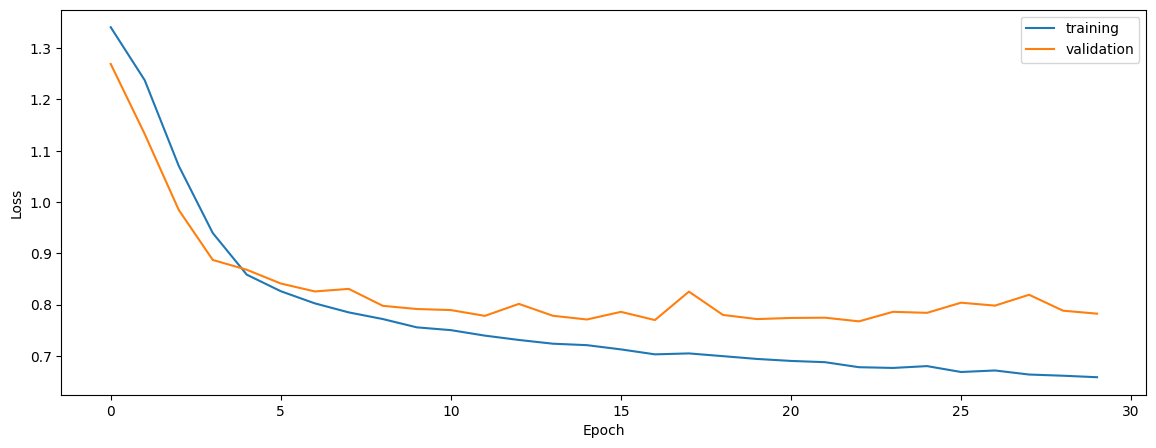

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


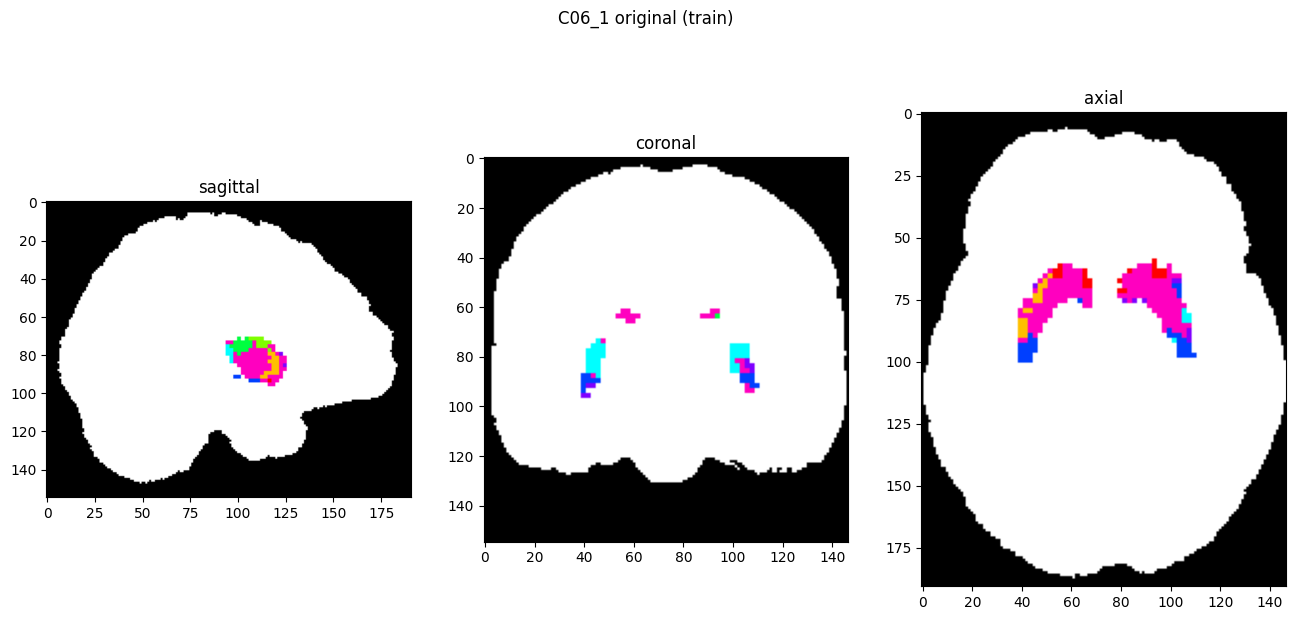

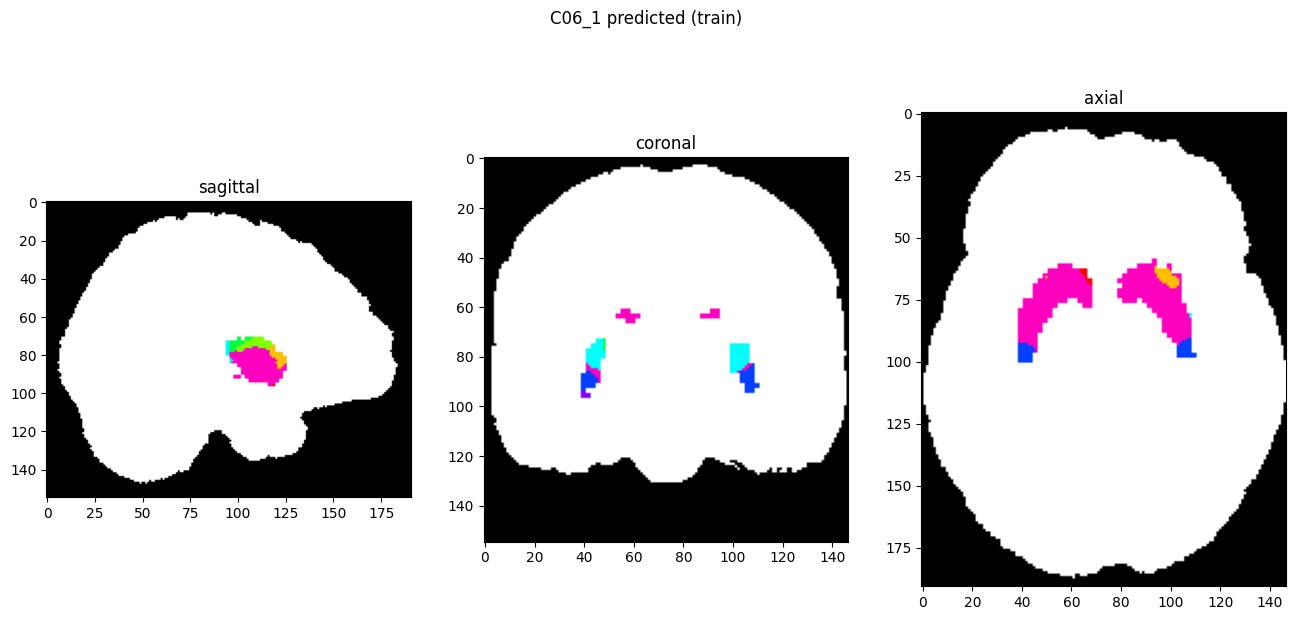

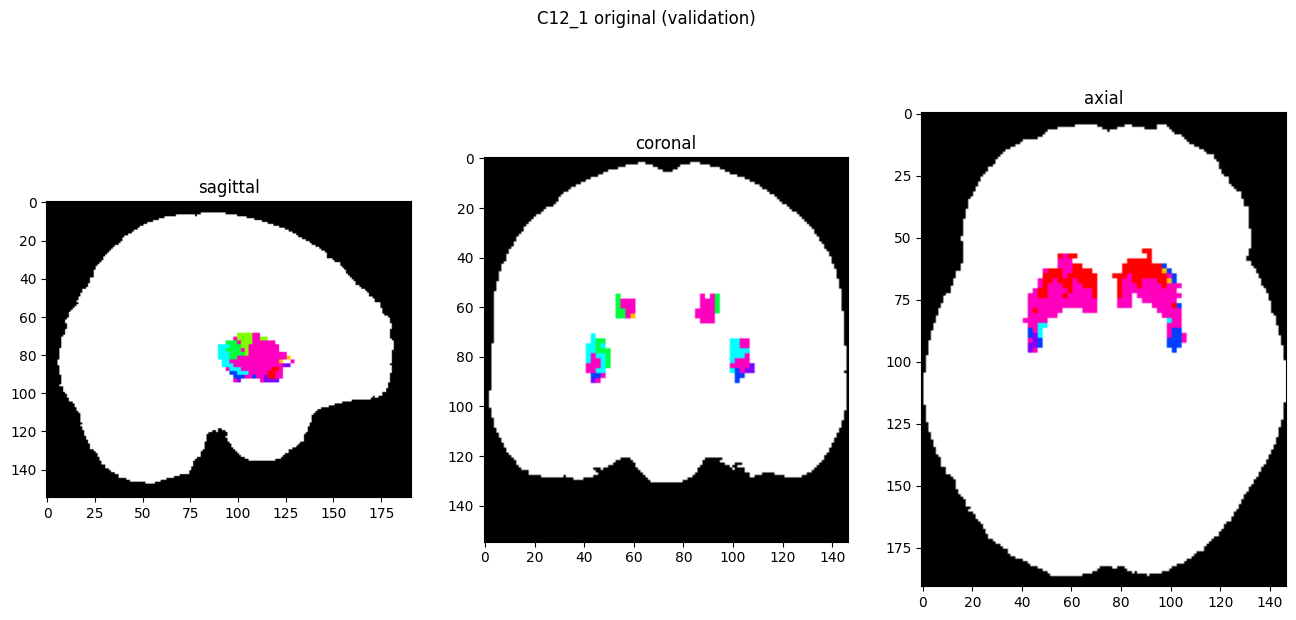

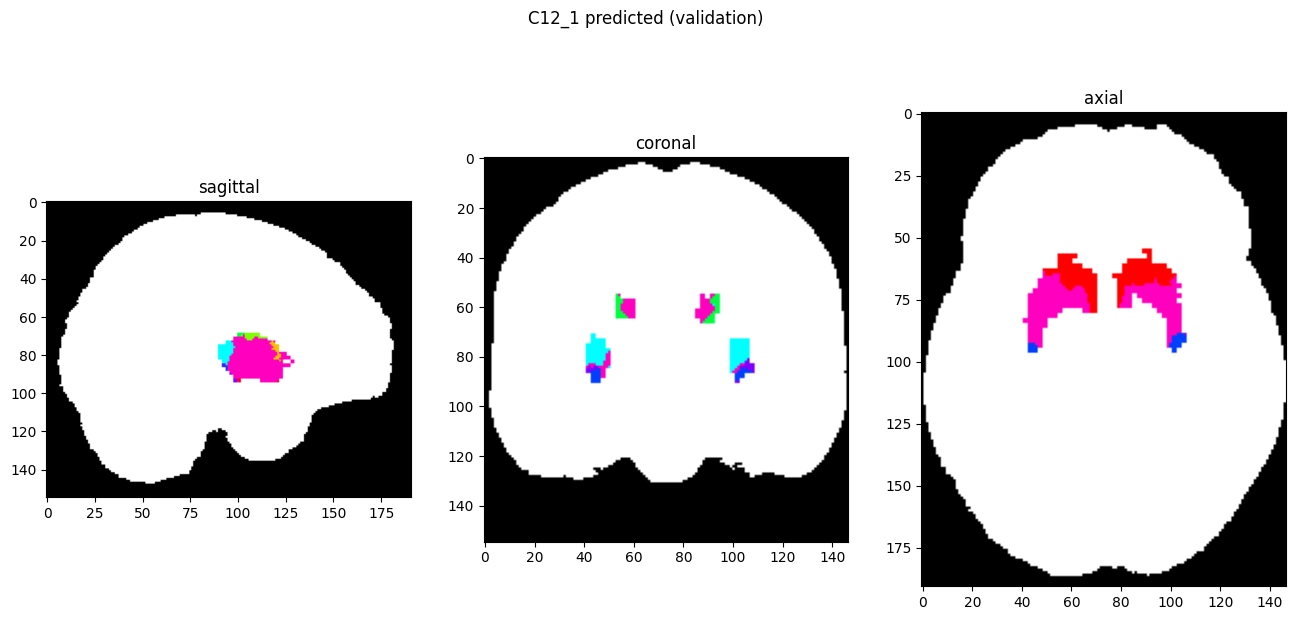

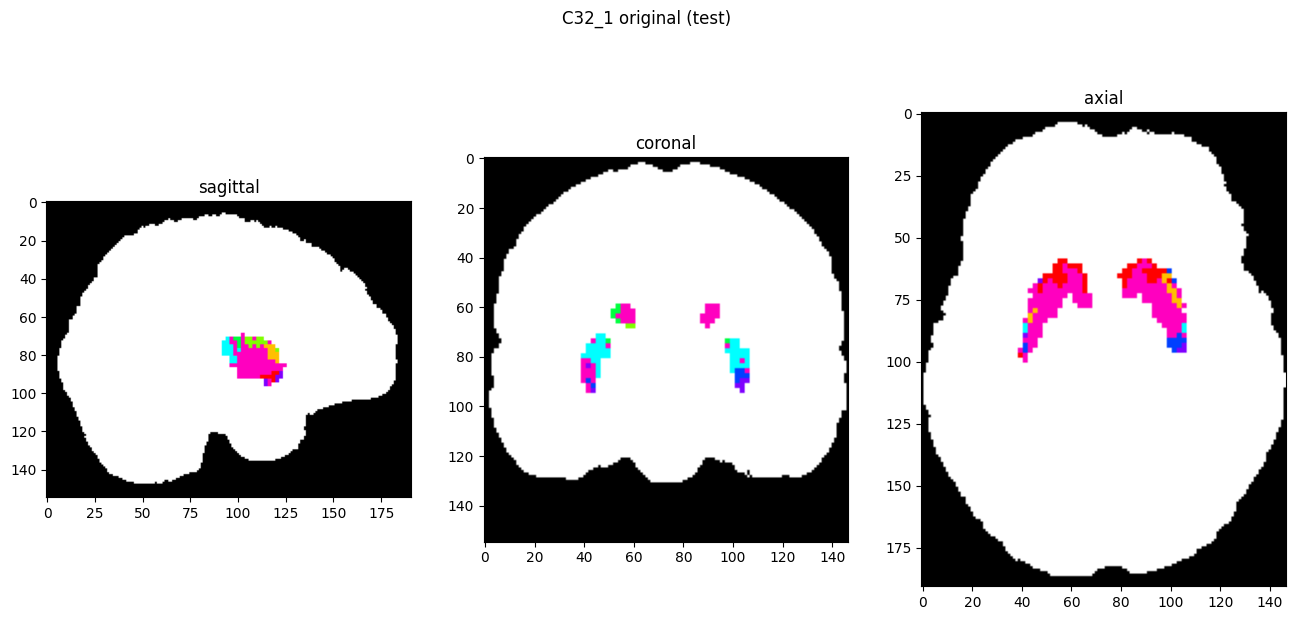

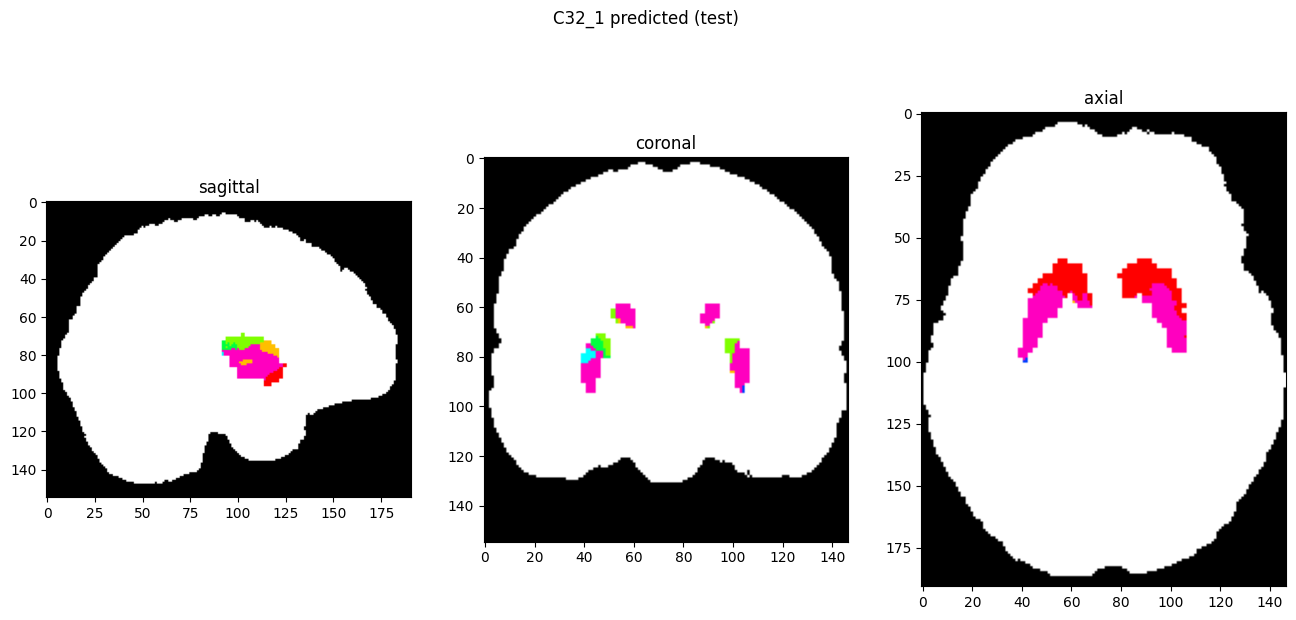

In [10]:
showResults(model, gen, threshold=0)